# Overview

This notebook uses data shared in this "data repo" (https://gin.g-node.org/gallantlab/story_listening/src/master) and code from this "code repo" (https://github.com/HuthLab/speechmodeltutorial) to  replicate the semantic model in Huth et al. (2016). The repository that this notebook lives in is a forked repo from the code repo. Files in the "data repo" are under "data/" directory in this forked repo along with data files that come with the code repo itself (see documentation). The "data/" directory is not present in this forked github repository due to size limit. 

In this notebook, we will:
- Inspect data in the data repo, check for data format, dimensions, and whether they are processed as described in Huth et al. (2016). If not, process them based on Huth et al. (2016).
    - Compare features provided in the data repo and in the code repo 
    - Compare averaged test data with individual repetition data
- Downsample word-level surprisal features to align with fMRI acquisition time (TR)
- Fit semantic model
- Map voxels to fsaverage

Tia Ou, 2025/12/20

In [2]:
# %pip install nibabel numpy pandas h5py tables scipy scikit-learn matplotlib

In [3]:
import numpy as np
import nibabel as nib
from os.path import join
import matplotlib.pyplot as plt
import scipy

import pandas as pd
import h5py
from pathlib import Path
# import pycortex

In [4]:
# helper functions

def load_hdf_all(p):
    hdf_data = {}
    print('Loading file:' + p)
    # Try h5py because some HDF files are plain HDF5
    try:
        with h5py.File(str(p), 'r') as f:
            print('h5py top-level groups:', list(f.keys()))
            def _visitor(name, obj):
                if isinstance(obj, h5py.Dataset):
                    try:
                        data = obj[()]
                        hdf_data['/' + name] = data
                        print(f'Loaded dataset /{name} shape={getattr(data, "shape", None)} dtype={getattr(data, "dtype", None)}')
                    except Exception as e2:
                        print(f'Failed to read dataset /{name}:', e2)
            f.visititems(_visitor)
    except Exception as e2:
        print('h5py open failed:', e2)

    # data now contains loaded objects (DataFrames, arrays, etc.)
    print('Loaded keys:', list(hdf_data.keys()))
    return hdf_data


def get_filelist(file_dir):
    if not file_dir.exists():
        print(f"Directory not found: {file_dir.resolve()}")
    else:
        file_list = sorted([p.name for p in file_dir.iterdir() if p.is_file()])
        print(f"Found {len(file_list)} files in {file_dir}:")
        for fname in    file_list:
            print(fname)
    return  file_list

import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz

def restore_csr(data, indices, indptr, shape):
    """
    Restore a scipy.sparse.csr_matrix from CSR components.

    Parameters
    - data: 1D array-like of nonzero values (length = nnz)
    - indices: 1D array-like of column indices for each nonzero (length = nnz)
    - indptr: 1D array-like of row pointer (length = n_rows + 1)
    - shape: tuple (n_rows, n_cols)

    Returns
    - csr: scipy.sparse.csr_matrix
    """
    data = np.asarray(data)
    indices = np.asarray(indices, dtype=np.int32)
    indptr = np.asarray(indptr, dtype=np.int32)

    n_rows, n_cols = tuple(shape)
    if indptr.ndim != 1 or len(indptr) != n_rows + 1:
        raise ValueError("`indptr` length must be n_rows + 1")
    if indices.ndim != 1 or data.ndim != 1 or len(indices) != len(data):
        raise ValueError("`data` and `indices` must be 1D and of equal length (nnz)")
    if indices.min() < 0 or indices.max() >= n_cols:
        raise IndexError("`indices` contains out-of-bounds column indices for given shape")

    csr = csr_matrix((data, indices, indptr), shape=shape)
    return csr



# Load and inspect feature matrix

In [5]:
# Load feature matrix
hdf_feat_mat = load_hdf_all('data\\features\\features_matrix.hdf')


Loading file:data\features\features_matrix.hdf
h5py top-level groups: ['diphone_test', 'diphone_train', 'numPhone_test', 'numPhone_train', 'numWords_test', 'numWords_train', 'powspec_test', 'powspec_train', 'semantic_test', 'semantic_train', 'single_test', 'single_train', 'triphone_test', 'triphone_train']
Loaded dataset /diphone_test shape=(291, 858) dtype=float64
Loaded dataset /diphone_train shape=(3737, 858) dtype=float64
Loaded dataset /numPhone_test shape=(291, 1) dtype=float64
Loaded dataset /numPhone_train shape=(3737, 1) dtype=float64
Loaded dataset /numWords_test shape=(291, 1) dtype=float64
Loaded dataset /numWords_train shape=(3737, 1) dtype=float64
Loaded dataset /powspec_test shape=(291, 448) dtype=float64
Loaded dataset /powspec_train shape=(3737, 448) dtype=float64
Loaded dataset /semantic_test shape=(291, 985) dtype=float64
Loaded dataset /semantic_train shape=(3737, 985) dtype=float64
Loaded dataset /single_test shape=(291, 39) dtype=float64
Loaded dataset /single_tra

Feature matrices are organized as time x feature. Among the many features, only four were used in the paper: 
1) Phoneme rate (1 feature): '/numPhone'
2) Word rate (1 feature): '/numWords'
3) Semantics (985 features): '/semantic'
4) Phonemes (39 features): '/single'

Training set: ten 10-15 min stories presented in separate runs. Each run has 10-second silence at the beginning and end.
Test set: one story played twice. Responses in this dataset have been averaged across two repetitions.


- "Before doing regression, we first z-scored **each feature channel** within each story. This was done to match the features to the fMRI responses, which were also z-scored within each story. However, this had little effect on the learned weights."

Well... have the feature channels been z-scored in this dataset we have?
- They have been z-scored within feature **categories**: All values within a feature category add up to 0 with std of 1.
- But, they are not z-scored within **channels!** As you will see in the figure below, each feature has different mean values and they are not equal to 0.


There are 3737 data points (124.57 minutes) in the train set.
There are 291 data points (9.70 minutes) in the test set.
Therefore, we only have the averaged data for the test set! Not both repetitions.
There are 1 features for /numPhone.
Overall /numPhone Train set mean: -1.8253171697342686e-16, std: 0.9999999999999999
Overall /numPhone Test set mean: -3.6625914214438153e-17, std: 1.0
There are 1 features for /numWords.
Overall /numWords Train set mean: 4.5632929243356714e-17, std: 1.0
Overall /numWords Test set mean: -4.883455228591754e-17, std: 1.0
There are 985 features for /semantic.
Overall /semantic Train set mean: -1.605549445776732e-17, std: 1.0
Overall /semantic Test set mean: -9.469441103157615e-18, std: 1.0
There are 39 features for /single.
Overall /single Train set mean: 1.8721201740864293e-17, std: 1.0
Overall /single Test set mean: -3.756504021993657e-17, std: 1.0


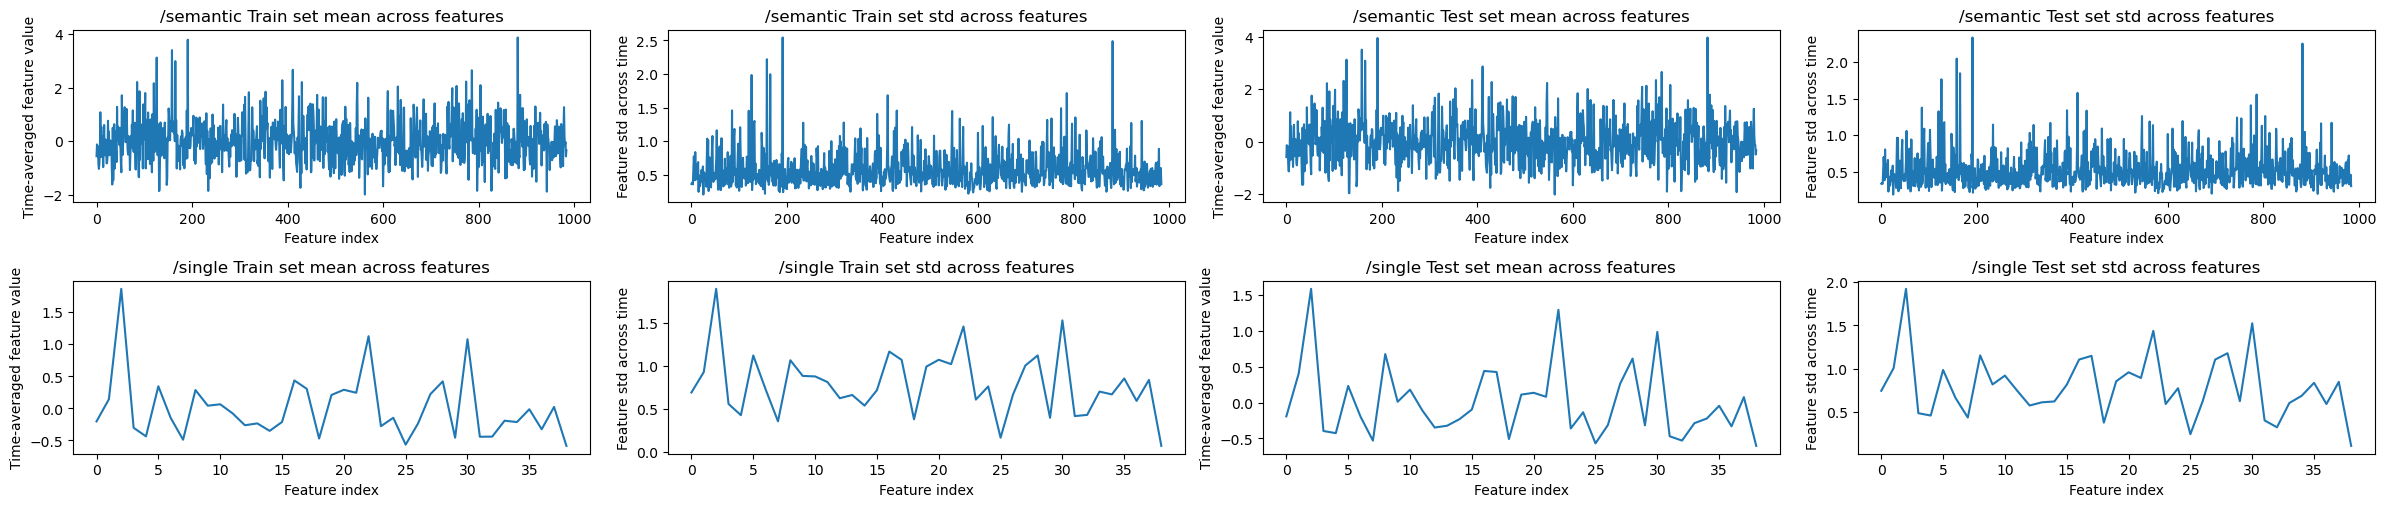

In [6]:
# In the paper, these features were used: 
feat_used = {'/numPhone': 1, '/numWords': 1,  '/semantic': 985, '/single': 39}
n_feat_cat = [1, 1, 985, 39]  # number of features in each category
# Inspect data lengths and feature counts
dp_train = hdf_feat_mat["/semantic_train"].shape[0]
dp_test = hdf_feat_mat["/semantic_test"].shape[0]
print(f'There are {dp_train} data points ({dp_train/30:.2f} minutes) in the train set.')
print(f'There are {dp_test} data points ({dp_test/30:.2f} minutes) in the test set.')
print('Therefore, we only have the averaged data for the test set! Not both repetitions.')
total_feat = 0
plt.figure(figsize=(6*len(feat_used),10))
for feat_name in feat_used:
    assert hdf_feat_mat[feat_name+"_train"].shape[1] == hdf_feat_mat[feat_name+"_test"].shape[1], f'Feature number mismatch in {feat_name}!'
    n_feat = hdf_feat_mat[feat_name+"_train"].shape[1]
    print(f'There are {n_feat} features for {feat_name}.')
    assert n_feat == feat_used[feat_name], f'Feature count for {feat_name} does not match expected {feat_used[feat_name]}!'
    # Have they gone through z-scoring already? 
    print(f'Overall {feat_name} Train set mean: {np.mean(hdf_feat_mat[feat_name+"_train"].flatten(),0)}, std: {np.std(hdf_feat_mat[feat_name+"_train"].flatten(),0)}')
    print(f'Overall {feat_name} Test set mean: {np.mean(hdf_feat_mat[feat_name+"_test"].flatten(),0)}, std: {np.std(hdf_feat_mat[feat_name+"_test"].flatten(),0)}')
    # skip plot for numPhone and numWords
    if feat_name in ['/numPhone', '/numWords']:
        total_feat += hdf_feat_mat[feat_name+"_train"].shape[1]
        continue
    # plot time-average for each feature
    plt.subplot(4,4,4*list(feat_used).index(feat_name)+1)
    plt.plot(np.mean(hdf_feat_mat[feat_name+"_train"],0))
    plt.ylabel('Time-averaged feature value')
    plt.xlabel('Feature index')
    plt.title(f'{feat_name} Train set mean across features')
    plt.subplot(4,4,4*list(feat_used).index(feat_name)+3)
    plt.plot(np.mean(hdf_feat_mat[feat_name+"_test"],0))
    plt.ylabel('Time-averaged feature value')
    plt.xlabel('Feature index')
    plt.title(f'{feat_name} Test set mean across features')
    # plot feature std across time
    plt.subplot(4,4,4*list(feat_used).index(feat_name)+2)
    plt.plot(np.std(hdf_feat_mat[feat_name+"_train"],0))
    plt.ylabel('Feature std across time')
    plt.xlabel('Feature index')
    plt.title(f'{feat_name} Train set std across features')
    plt.subplot(4,4,4*list(feat_used).index(feat_name)+4)
    plt.plot(np.std(hdf_feat_mat[feat_name+"_test"],0))
    plt.ylabel('Feature std across time')
    plt.xlabel('Feature index')
    plt.title(f'{feat_name} Test set std across features')
   
    total_feat += hdf_feat_mat[feat_name+"_train"].shape[1]
plt.tight_layout()
plt.show()
assert total_feat == sum(n_feat_cat), f'Total feature count does not match sum of individual feature counts! Should be {sum(n_feat_cat)}, but got {total_feat}.' 



Has the 10-second silence been trimmed away? 
Yes - because feature values in the first 10 seconds are non-zeros and varying. See below.

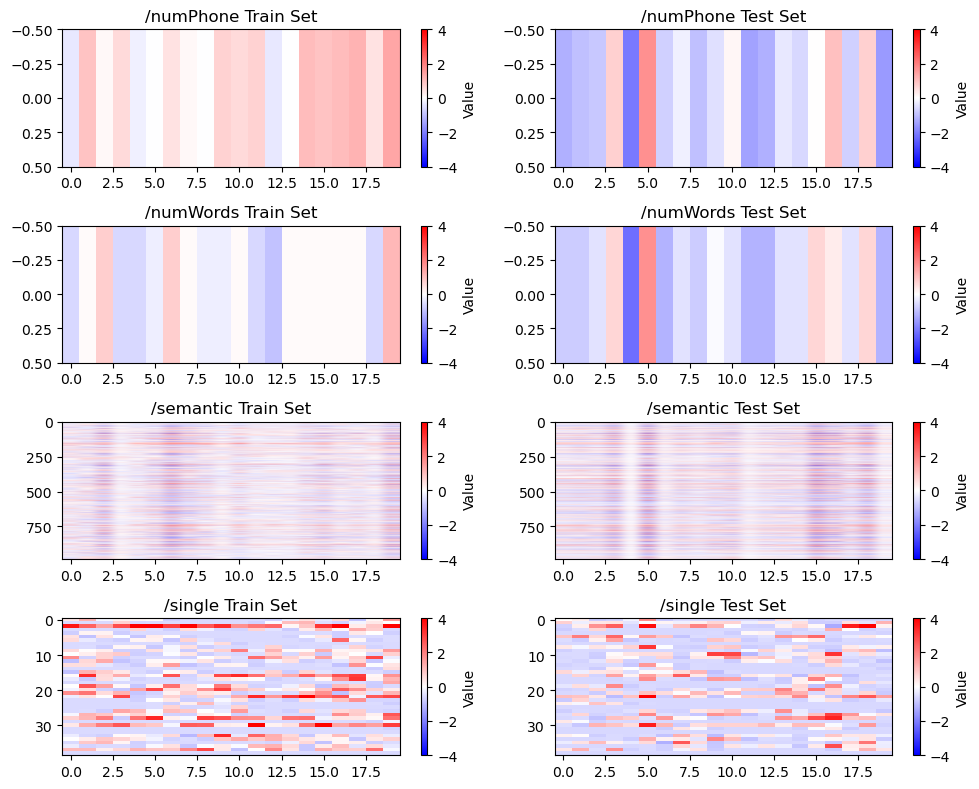

In [7]:
# examine feature time courses of first 40 seconds
plt.figure(figsize=(10,2*len(feat_used)))
# separate train and test for visualization
for feat_name in feat_used:
    plt.subplot(len(feat_used), 2,list(feat_used).index(feat_name)*2+1)
    plt.imshow(hdf_feat_mat[feat_name+"_train"][:20,:].T, aspect='auto', cmap='bwr', clim=(-4, 4))
    plt.title(feat_name + ' Train Set')
    plt.colorbar(label='Value')
    plt.subplot(len(feat_used), 2,list(feat_used).index(feat_name)*2+2)
    plt.imshow(hdf_feat_mat[feat_name+"_test"][:20,:].T, aspect='auto', cmap='bwr', clim=(-4, 4))
    plt.title(feat_name + ' Test Set')
    plt.colorbar(label='Value')
 
plt.tight_layout()
plt.show()
# Why is phoneme representation not binary? Because of the 3-lobe Lanczos filter used to match fMRI acquisition times.

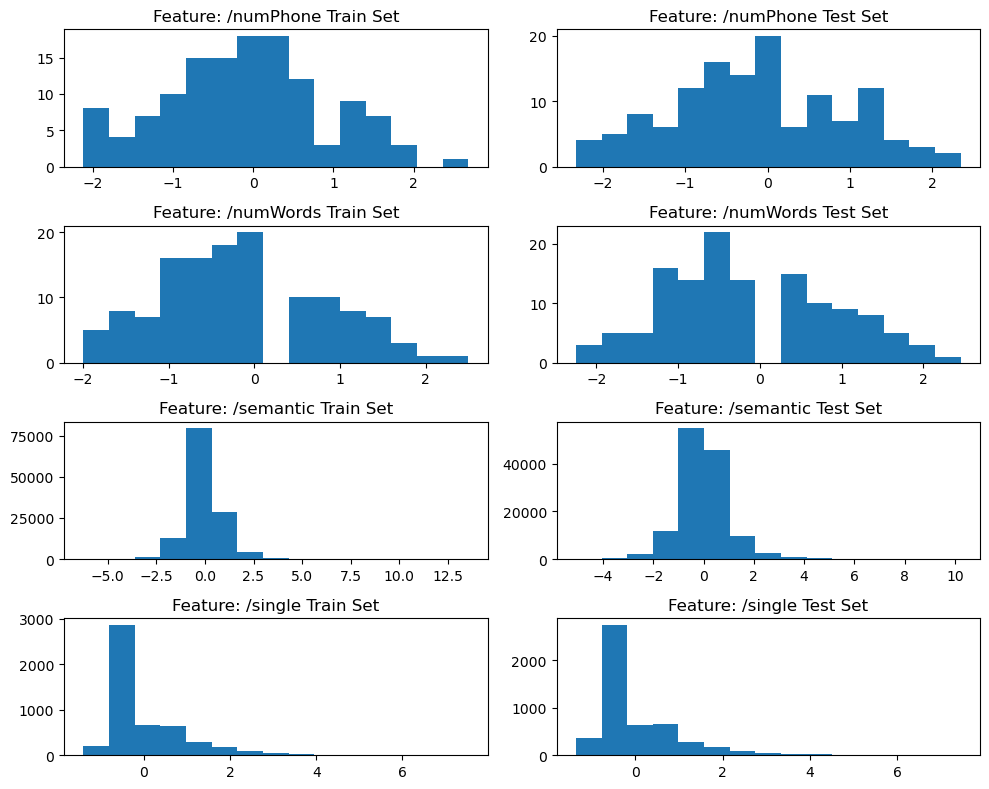

In [8]:
# examine feature distributions
plt.figure(figsize=(10,2*len(feat_used)))
for feat_name in feat_used:
    plt.subplot(len(feat_used), 2,list(feat_used).index(feat_name)*2+1)
    plt.hist((hdf_feat_mat[feat_name+"_train"][np.linspace(0, hdf_feat_mat[feat_name+"_train"].shape[0]-1,130).astype(int), :]).flatten(), bins=15)
    plt.title(f'Feature: {feat_name} Train Set')
    plt.subplot(len(feat_used), 2,list(feat_used).index(feat_name)*2+2)
    plt.hist((hdf_feat_mat[feat_name+"_test"][np.linspace(0, hdf_feat_mat[feat_name+"_test"].shape[0]-1,130).astype(int), :]).flatten(), bins=15)
    plt.title(f'Feature: {feat_name} Test Set')
plt.tight_layout()
plt.show()


## Use data from the code repo to check against the data repo

Data files that come with this code repo have all the stories and text grids, which the data repo doesn't have.
However, this code does not explicitly compute phoneme rate, word rate, and phonemes. It only gives us the semantic features.
It would be helpful to compare it with our semantic features.

- "Transcript preprocessing:
The aligned transcripts were converted into separate word and phoneme representations. The phoneme representation of each story is a list of pairs (p,t), where p is a phoneme and t is the time from the beginning of the story to the middle of the phoneme (that is, halfway between the start and end of the phoneme) in seconds. Similarly the word representation of each story is a list of pairs (w,t), where w is a word.
- For each word–time pair (w,t) in each story we selected the corresponding column of M, creating a new list of semantic vector–time pairs, (Mw,t). These vectors were then **resampled at times corresponding to the fMRI acquisitions** using a **3-lobe Lanczos filter** with the cut-off frequency set to the Nyquist frequency of the fMRI acquisition **(0.249 Hz)**."

In [9]:
from SemanticModel import SemanticModel
eng1000 = SemanticModel.load("data/english1000sm.hf5")
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence']

# Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

# Load TextGrids
from stimulus_utils import load_grids_for_stories
grids = load_grids_for_stories(allstories)

# Load TRfiles
from stimulus_utils import load_generic_trfiles
trfiles = load_generic_trfiles(allstories)

# Make word and phoneme datasequences
from dsutils import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

# Project stimuli
from dsutils import make_semantic_model
semanticseqs = dict() # dictionary to hold projected stimuli {story name : projected DataSequence}
for story in allstories:
    semanticseqs[story] = make_semantic_model(wordseqs[story], eng1000)

# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=window)

# Combine stimuli
from npp import zscore
trim = 5
Rstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories])
Pstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Pstories])



Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


In [10]:
import csv
# Since training data in the data repo were concatenated across stories, we need to find out the boundries using files provided in the code repo.
curr_idx = 0
story_idx = 0
story_boundaries = dict()
story_idx_TR = []
for story in Rstories:
    n_dp = downsampled_semanticseqs[story][5+trim:-trim].shape[0]
    story_boundaries[story] = (curr_idx, curr_idx + n_dp)
    story_idx_TR.append(story_idx * np.ones([n_dp,1]))
    curr_idx += n_dp
    story_idx += 1
print(f'Story boundaries {story_boundaries}')
# According to how the stimuli are ordered (in the data/stimuli/ directory), the order of hdf_feat_mat is the same as the Rstories list above.
story_idx_TR = np.vstack(story_idx_TR)
print(story_idx_TR)
with open('results/story_idx.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for row in story_idx_TR:
            writer.writerow(row)


Story boundaries {'alternateithicatom': (0, 343), 'avatar': (343, 710), 'howtodraw': (710, 1064), 'legacy': (1064, 1464), 'life': (1464, 1894), 'myfirstdaywiththeyankees': (1894, 2252), 'naked': (2252, 2674), 'odetostepfather': (2674, 3078), 'souls': (3078, 3433), 'undertheinfluence': (3433, 3737)}
[[0.]
 [0.]
 [0.]
 ...
 [9.]
 [9.]
 [9.]]


In [11]:
# find which element in wordseqs[story].data is empty and remove them
for story in allstories:
    empty_indices = [i for i, word in enumerate(wordseqs[story].data) if word == '']
    print(f'Empty word entries in {story} at indices: {empty_indices}')
    # remove these empty entries in wordseqs[story].data and wordseqs[story].data_times.
    wordseqs[story].data = [word for i, word in enumerate(wordseqs[story].data) if i not in empty_indices]
    wordseqs[story].data_times = [time for i, time in enumerate(wordseqs[story].data_times) if i not in empty_indices]

Empty word entries in alternateithicatom at indices: []
Empty word entries in avatar at indices: [808]
Empty word entries in howtodraw at indices: []
Empty word entries in legacy at indices: [57]
Empty word entries in life at indices: []
Empty word entries in myfirstdaywiththeyankees at indices: []
Empty word entries in naked at indices: [287]
Empty word entries in odetostepfather at indices: [417, 1384, 1396, 1532, 1534]
Empty word entries in souls at indices: []
Empty word entries in undertheinfluence at indices: []
Empty word entries in wheretheressmoke at indices: []


In [12]:
# check if word and timing correspond
for story in wordseqs:
    print(f'Story: {story}, data times length: {len(wordseqs[story].data_times)}, word count: {len(wordseqs[story].data)}')

Story: alternateithicatom, data times length: 2174, word count: 2174
Story: avatar, data times length: 1468, word count: 1468
Story: howtodraw, data times length: 1964, word count: 1964
Story: legacy, data times length: 1892, word count: 1892
Story: life, data times length: 2209, word count: 2209
Story: myfirstdaywiththeyankees, data times length: 2786, word count: 2786
Story: naked, data times length: 3217, word count: 3217
Story: odetostepfather, data times length: 2670, word count: 2670
Story: souls, data times length: 1868, word count: 1868
Story: undertheinfluence, data times length: 1641, word count: 1641
Story: wheretheressmoke, data times length: 1839, word count: 1839


## Downsample surprisal
We want to add word-level surprisal features to our analysis and get the relationship between low-level features and surprisal, but all we have is downsampled features. Therefore, we need to downsample the surprisal features. Here we downsample them to TR times using Lanczos interpolation.

In [17]:
# make a function that downsample features with input variables: features, story
def downsample_features(features,story):
    from interpdata import lanczosinterp2D
    Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence']

    # Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
    Pstories = ['wheretheressmoke']

    allstories = Rstories + Pstories

    # Load TextGrids and TR files
    from stimulus_utils import load_grids_for_stories,load_generic_trfiles
    grids = load_grids_for_stories(allstories)
    trfiles = load_generic_trfiles(allstories)

    # Make word and phoneme datasequences
    from dsutils import make_word_ds
    wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}

    # check if the story is valid
    assert story in allstories, f'Story {story} not found in allstories! Stories available: {allstories}'
    
    # check if features is 1D, if so, reshape to 2D with one column
    if features.ndim == 1:
        features = features.reshape(-1, 1)
    # check if feature length matches wordseqs[story] length, if not, transpose and check again
    if features.shape[0] != len(wordseqs[story].data):
        features = features.T
        assert features.shape[0] == len(wordseqs[story].data), f'Feature length {features.shape[0]} does not match word count {len(wordseqs[story].data)} for story {story} even after transposing!'
    
    print(f'Downsampling {features.shape[1]} feature(s) for story {story}...')

    trim = 5
    downsampled_features = np.zeros((len(wordseqs[story].tr_times)-5-2*trim, features.shape[1]))  # Initialize downsampled_features with correct shape
    # loop through each feature to process
    for i in range(features.shape[1]):
        print(f'Processing feature {i+1}/{features.shape[1]}:')
        feature = features[:, i]
        # check if feature has NaN values and fill in with mean of the feature
        print(f"Number of NaN values in feature: {np.sum(np.isnan(feature))}")

        if np.any(np.isnan(feature)):
            mean_feat = np.nanmean(feature)
            feat_nonan = np.where(np.isnan(feature), mean_feat, feature)
            print(f"Filled NaN values with mean value: {mean_feat}")

        # z-score the feature
        feat_nonan_zscore = (feat_nonan - np.mean(feat_nonan))/ np.std(feat_nonan)

        # downsample the feature to fMRI TRs using lanczos interpolation
        feature_downsampled = lanczosinterp2D(feat_nonan_zscore,wordseqs[story].data_times, wordseqs[story].tr_times, window=3,cutoff_mult=0.5)

        # trim TRs and z-score
        feature_downsampled_trimmed = feature_downsampled[5+trim:-trim]
        feature_downsampled_trimmed_zscore = (feature_downsampled_trimmed - np.mean(feature_downsampled_trimmed))/ np.std(feature_downsampled_trimmed)
        # store back
        downsampled_features[:, i] = feature_downsampled_trimmed_zscore.squeeze()
    return downsampled_features
    


In [18]:
story = 'howtodraw'
path_5gram = f"data\\surprisal\\{story}_word_sequence_surprisal-5gram-word-level.csv"
# load 5gram surprisal features
import pandas as pd
df_5gram = pd.read_csv(path_5gram)  
surprisal_5gram = df_5gram['surprisal-5gram'].to_numpy()
# copy surprisal_5gram to the second column to make it 2D
surprisal_5gram = np.column_stack((surprisal_5gram, surprisal_5gram))
# downsample
downsampled_5gram = downsample_features(surprisal_5gram, story)


Downsampling 2 feature(s) for story howtodraw...
Processing feature 1/2:
Number of NaN values in feature: 3
Filled NaN values with mean value: 2.555389109826812
Doing lanczos interpolation with cutoff=0.249 and 3 lobes.
Processing feature 2/2:
Number of NaN values in feature: 3
Filled NaN values with mean value: 2.555389109826812
Doing lanczos interpolation with cutoff=0.249 and 3 lobes.


In [12]:
def downsample_suprisal(path_in,story,data_times,tr_times,surprisal_type,wantplot=False):
    from interpdata import lanczosinterp2D

    if surprisal_type == 'gpt':
        column_name = 'surprisal-gpt2-xl'
    elif surprisal_type == '5gram':
        column_name = 'surprisal-5gram'

    # load file
    try:
        df = pd.read_csv(path_in)
        surprisal_seqs = df[column_name].to_numpy()
        # any empty values?
        print(f"Number of NaNs in {surprisal_type}:", np.sum(np.isnan(surprisal_seqs)))
        # fill in NaNs in surprisal_seqs with mean surprisal
        if np.isnan(surprisal_seqs).any():
           
            mean_surprisal = np.nanmean(surprisal_seqs)
            surprisal_seqs_nonan = np.where(np.isnan(surprisal_seqs), mean_surprisal, surprisal_seqs)
            print("Filled NaNs with mean surprisal:", mean_surprisal)
        else:
            surprisal_seqs_nonan = surprisal_seqs
            
        print(f"Loaded surprisal for {story}: {path_in} shape={surprisal_seqs_nonan.shape}")
        data_times_nonan = data_times
        
        surprisal_seqs_nonan_zscore = (surprisal_seqs_nonan - np.mean(surprisal_seqs_nonan))/ np.std(surprisal_seqs_nonan)

    except FileNotFoundError:
        print(f"File not found: {path_in}")
        surprisal_seqs_nonan = None
        surprisal_seqs_nonan_zscore = None
    
    # downsample 
    trim = 5   
    downsampled_surprisal = lanczosinterp2D(surprisal_seqs_nonan_zscore, data_times_nonan, tr_times,cutoff_mult=0.5)
    downsampled_surprisal_trimmed = zscore(downsampled_surprisal[5+trim:-trim])

    if wantplot:         
        
        s_sem = surprisal_seqs_nonan_zscore
        s_semdown = downsampled_surprisal

        f = plt.figure(figsize=(15,5))
        f.clf()
        ax = f.add_subplot(2,1,1)
        wordstems = ax.stem(data_times_nonan, 
                            zscore(s_sem), 
                            linefmt="k-", markerfmt="k.", basefmt="k-")
        interps = ax.plot(tr_times, 
                        zscore(s_semdown), 'r.-')
        ax.set_xlim(-6, 300)
        ax.set_ylim(-6, 6)
        ax.set_xlabel("Time (seconds since story start)")
        ax.set_ylabel("Surprisal value")
        ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));
        ax.set_title(f"Surprisal downsampling for {story} ({surprisal_type})")

    return downsampled_surprisal_trimmed,surprisal_seqs_nonan_zscore, surprisal_seqs_nonan

Number of NaNs in 5gram: 3
Filled NaNs with mean surprisal: 2.661887397518634
Loaded surprisal for alternateithicatom: data\surprisal\alternateithicatom_word_sequence_surprisal-5gram-word-level.csv shape=(2174,)
Doing lanczos interpolation with cutoff=0.249 and 3 lobes.
Number of NaNs in gpt: 0
Loaded surprisal for alternateithicatom: data\surprisal\alternateithicatom_word_sequence_surprisal-gpt2-xl-stride-128-word-level.csv shape=(2174,)
Doing lanczos interpolation with cutoff=0.249 and 3 lobes.
Correlation between original 5gram and gpt surprisal: 0.5941130307776475
Correlation between downsampled 5gram and gpt surprisal: 0.6056131947065377
Number of NaNs in 5gram: 2
Filled NaNs with mean surprisal: 2.5968012710922688
Loaded surprisal for avatar: data\surprisal\avatar_word_sequence_surprisal-5gram-word-level.csv shape=(1468,)
Doing lanczos interpolation with cutoff=0.249 and 3 lobes.
Number of NaNs in gpt: 0
Loaded surprisal for avatar: data\surprisal\avatar_word_sequence_surprisal-g

C:\Users\ou000036\AppData\Local\Temp\ipykernel_22292\4283452489.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(15,5))


Number of NaNs in gpt: 0
Loaded surprisal for wheretheressmoke: data\surprisal\wheretheressmoke_word_sequence_surprisal-gpt2-xl-stride-128-word-level.csv shape=(1839,)
Doing lanczos interpolation with cutoff=0.249 and 3 lobes.
Correlation between original 5gram and gpt surprisal: 0.5740530215549181
Correlation between downsampled 5gram and gpt surprisal: 0.5606019237767385


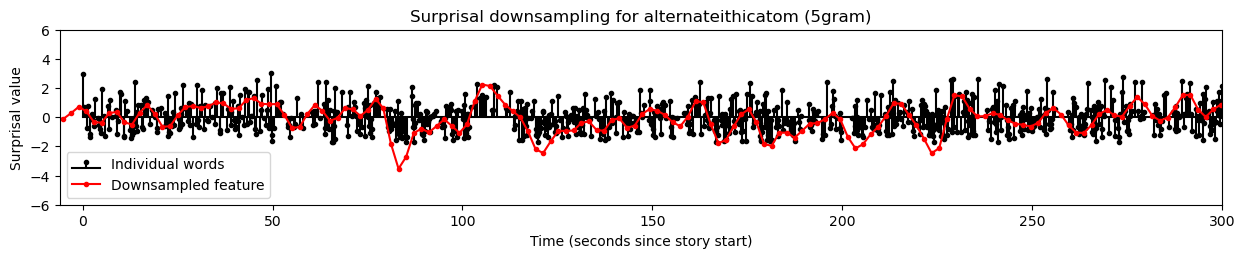

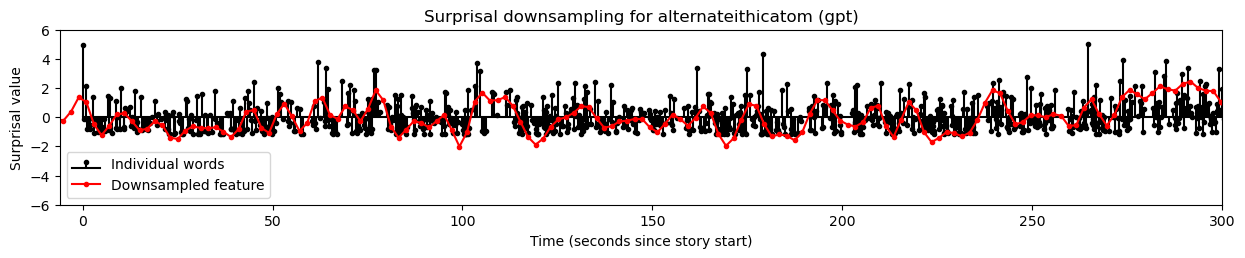

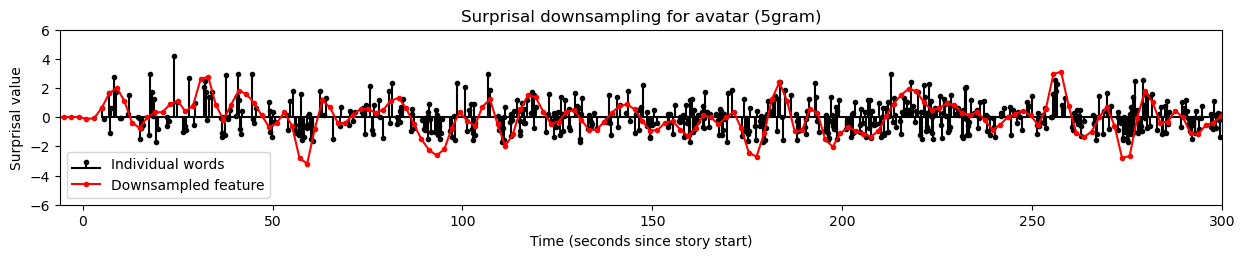

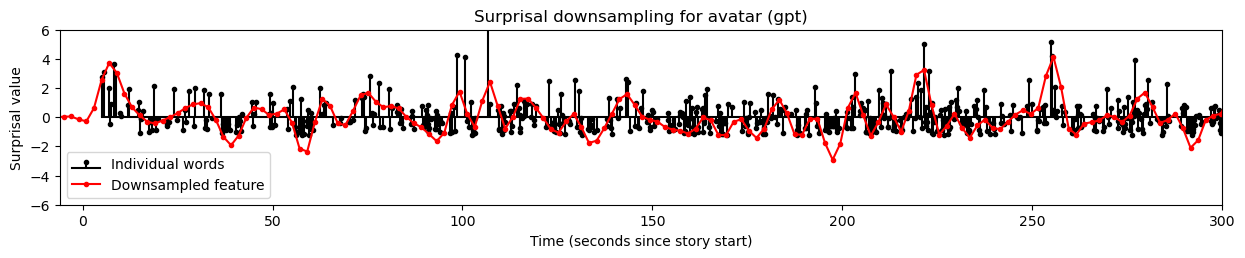

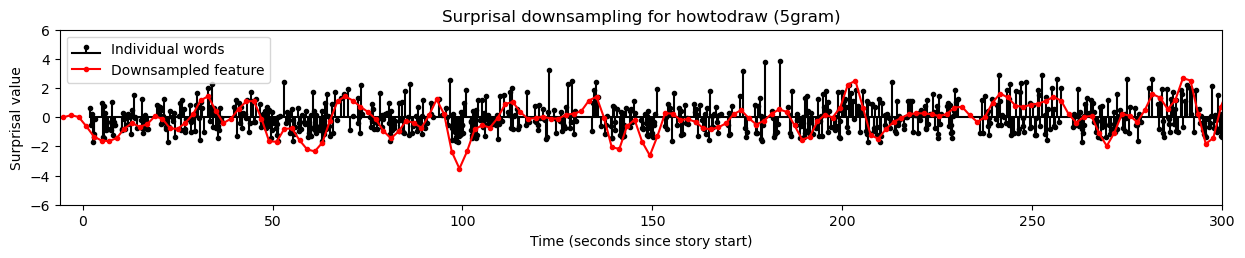

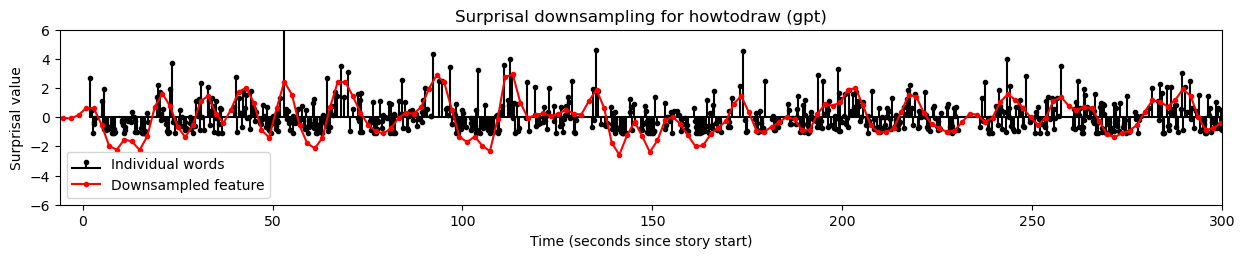

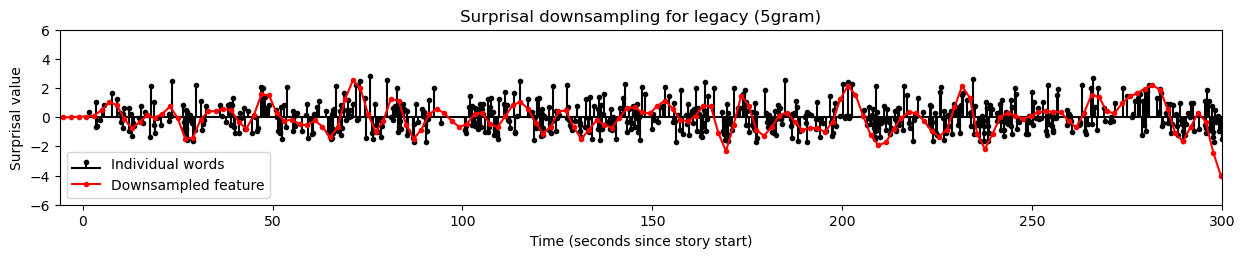

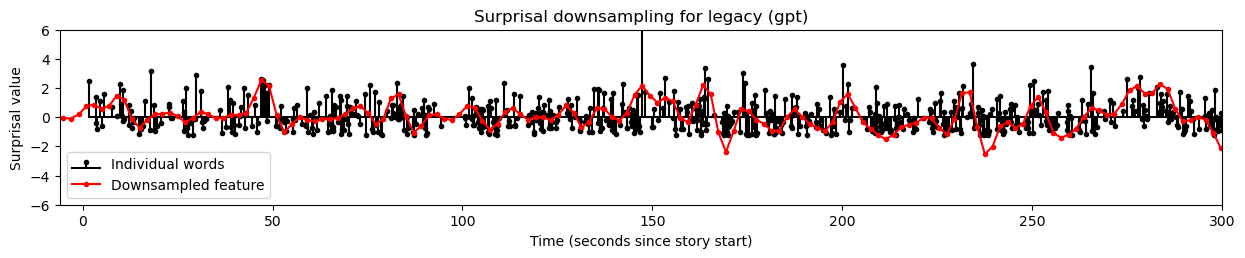

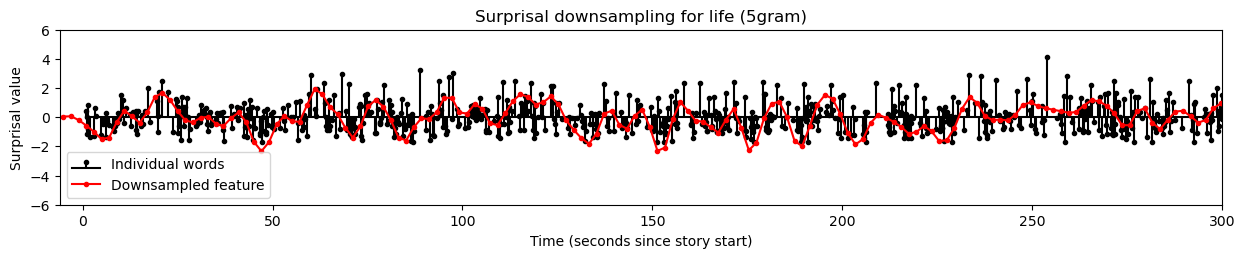

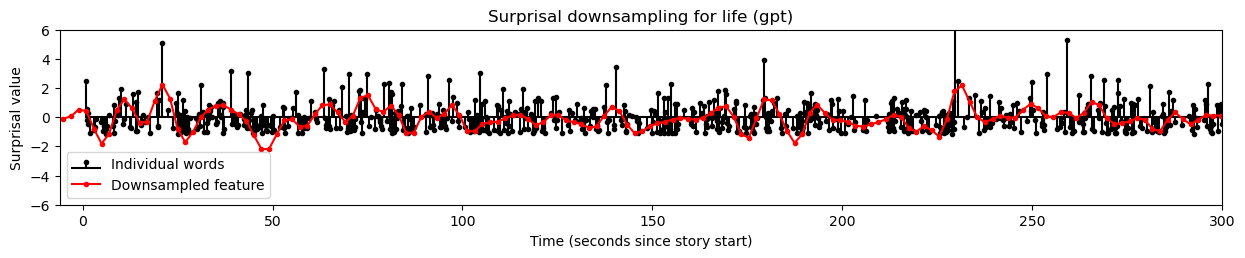

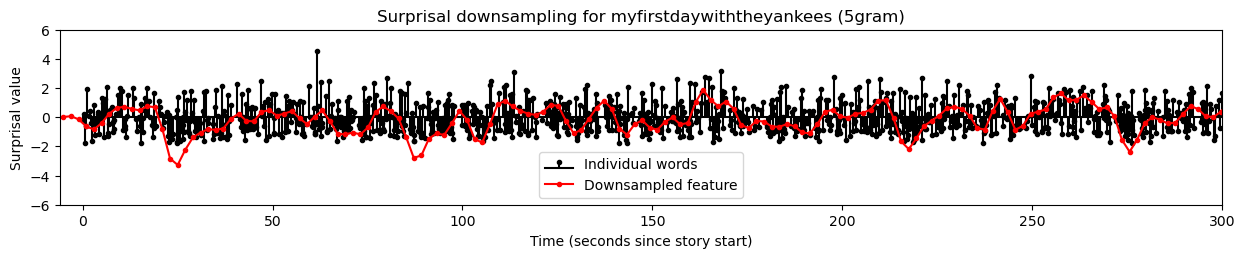

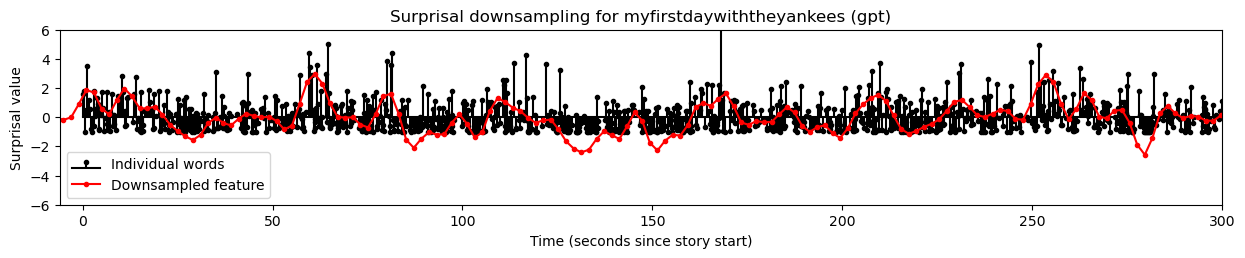

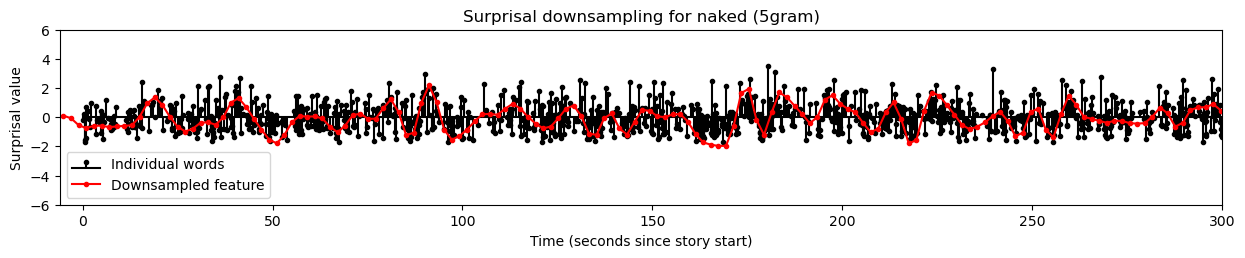

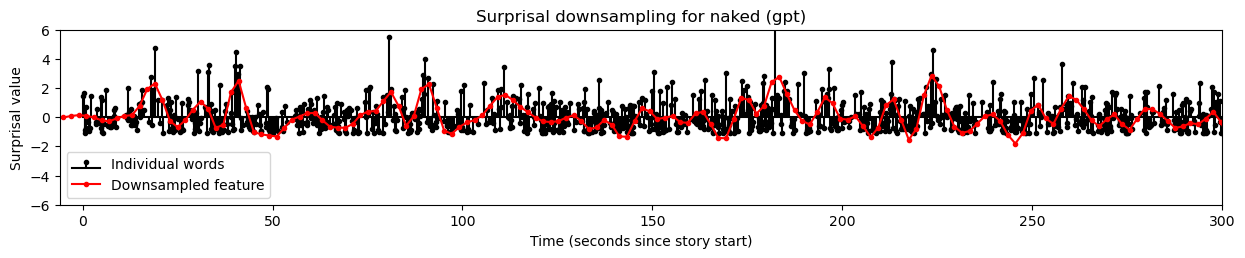

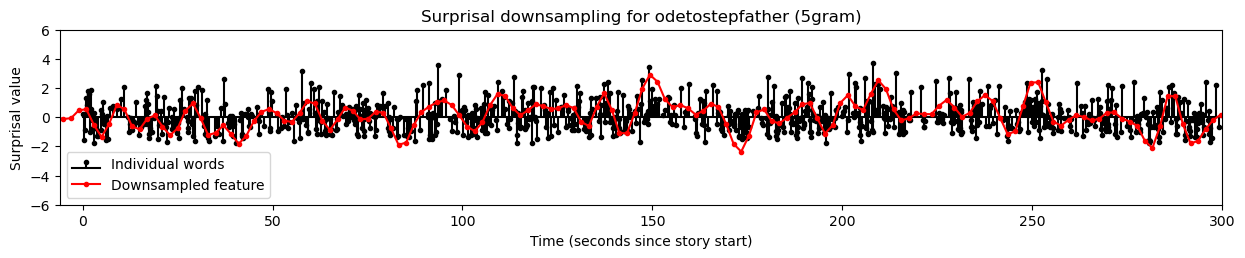

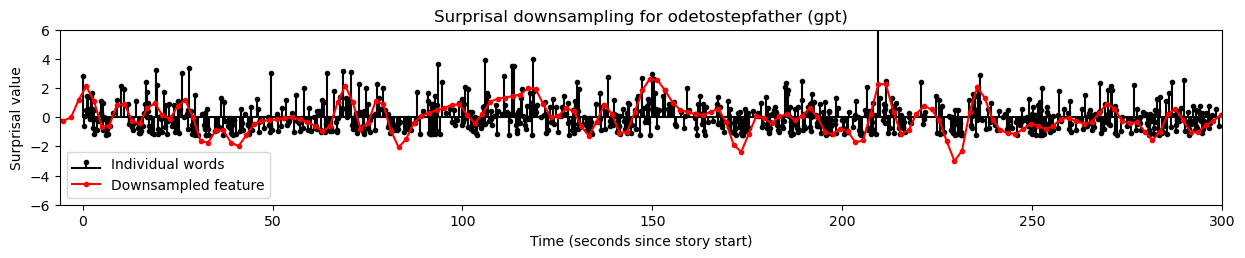

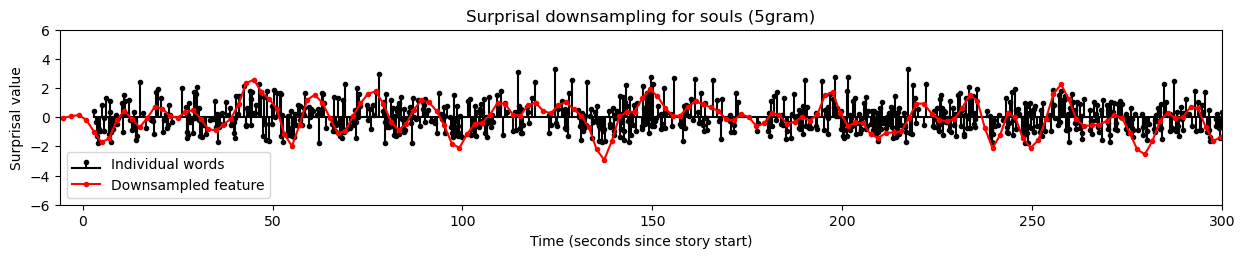

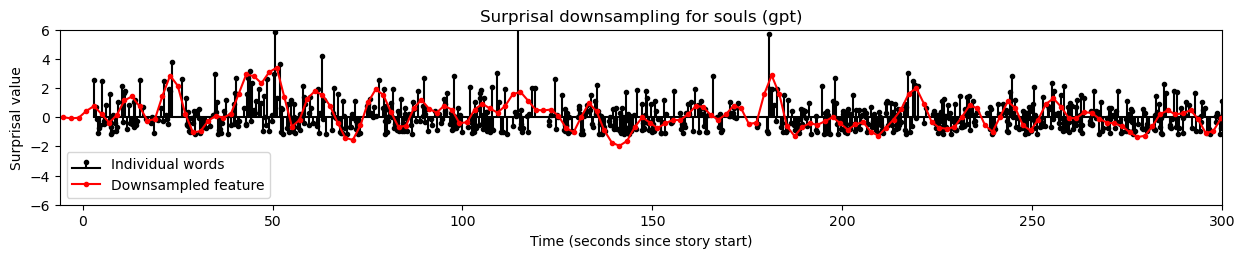

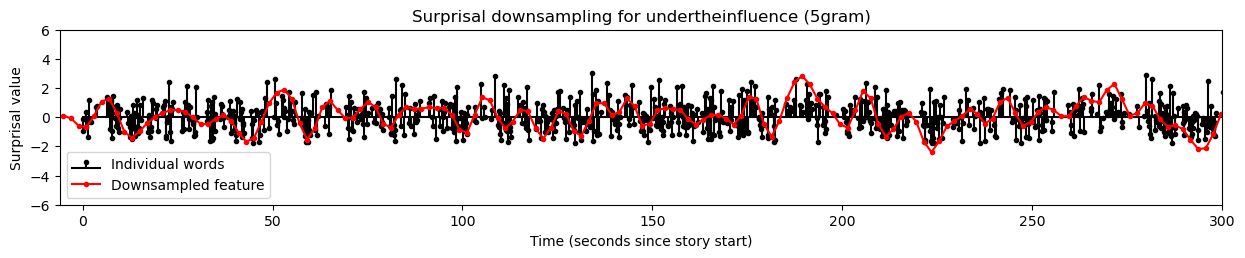

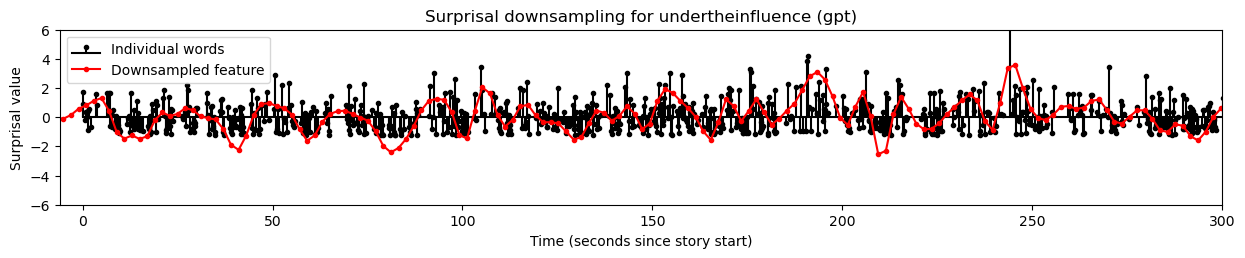

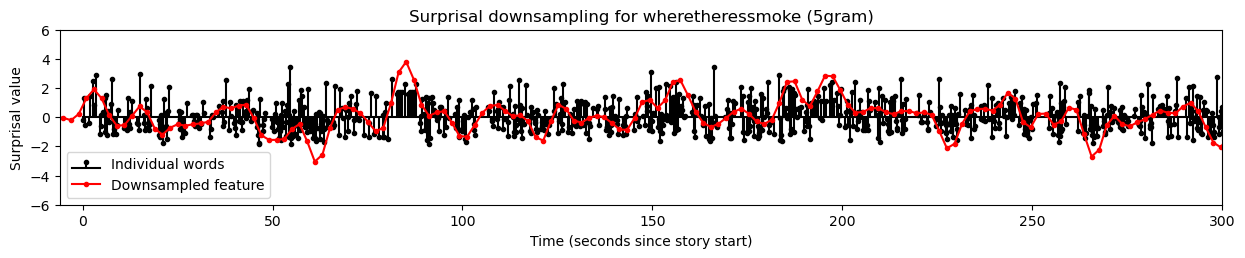

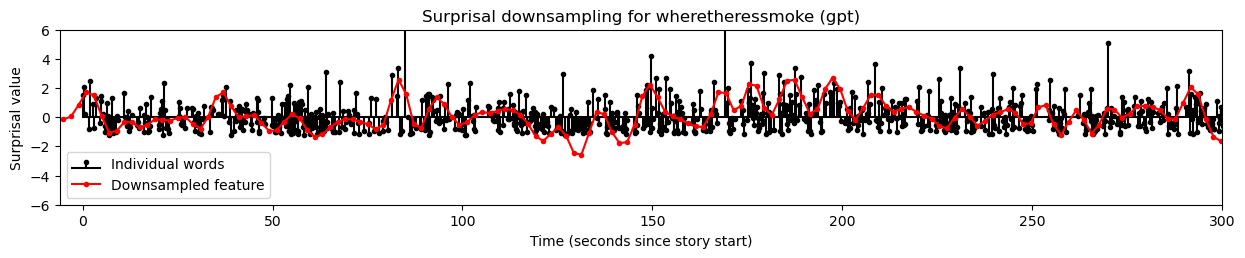

In [13]:
# export surprisal features along with other features to csv files
import os
import csv
output_dir = 'data\\surprisal\\'
story_count = 0
for story in allstories:
    
    # downsample surprisal
    path_5gram = f"data\\surprisal\\{story}_word_sequence_surprisal-5gram-word-level.csv"
    path_gpt = f"data\\surprisal\\{story}_word_sequence_surprisal-gpt2-xl-stride-128-word-level.csv"
    downsampled_5gram, surprisal_5gram_zscore,surprisal_5gram = downsample_suprisal(path_5gram,
                                        story,wordseqs[story].data_times, wordseqs[story].tr_times,'5gram',wantplot=True)
    downsampled_gpt, surprisal_gpt_zscore,surprisal_gpt = downsample_suprisal(path_gpt,
                                        story,wordseqs[story].data_times, wordseqs[story].tr_times,'gpt',wantplot=True)
    
    downsampled_5gram = np.expand_dims(downsampled_5gram, axis=1)
    downsampled_gpt = np.expand_dims(downsampled_gpt, axis=1)
    print(f'Correlation between original 5gram and gpt surprisal: {np.corrcoef(surprisal_5gram.flatten(), surprisal_gpt.flatten())[0,1]}')
    print(f'Correlation between downsampled 5gram and gpt surprisal: {np.corrcoef(downsampled_5gram.flatten(), downsampled_gpt.flatten())[0,1]}')


    # export word-level features
    if story == 'wheretheressmoke':
        surprisal_output_path = os.path.join(output_dir, f'test_{story}_surprisal_wordlevel.csv')
    else:
        surprisal_output_path = os.path.join(output_dir, f'train{story_count}_{story}_surprisal_wordlevel.csv')
        
    os.makedirs(os.path.dirname(output_dir), exist_ok=True)
    with open(surprisal_output_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # header
        writer.writerow(['word','data_time','surprisal_5gram','surprisal_gpt2-xl','surprisal_5gram_zscored','surprisal_gpt_zscored'])
     
        # ensure all lists are of the same length
        assert len(wordseqs[story].data)==len(wordseqs[story].data_times)==len(surprisal_5gram)
        for ii in range(len(wordseqs[story].data)):
            row = [wordseqs[story].data[ii],wordseqs[story].data_times[ii],surprisal_5gram[ii],surprisal_gpt[ii],surprisal_5gram_zscore[ii],surprisal_gpt_zscore[ii]]
            writer.writerow(row)
   
   
    
    # export TR level features
    if story == 'wheretheressmoke':
        word_rate = hdf_feat_mat['/numWords_test']
        phoneme_rate = hdf_feat_mat['/numPhone_test']
        phoneme = hdf_feat_mat['/single_test']
        word_output_path = os.path.join(output_dir, f'test_{story}_low_level_features_surprisal_zscore.csv')
          
    else:   
        word_rate = hdf_feat_mat['/numWords_train'][story_boundaries[story][0]:story_boundaries[story][1],:]
        phoneme_rate = hdf_feat_mat['/numPhone_train'][story_boundaries[story][0]:story_boundaries[story][1],:]
        phoneme = hdf_feat_mat['/single_train'][story_boundaries[story][0]:story_boundaries[story][1],:]
        word_output_path = os.path.join(output_dir, f'train{story_count}_{story}_low_level_features_surprisal_zscore.csv')
        story_count += 1 
    all_feats = np.concatenate([word_rate, phoneme_rate, phoneme, downsampled_5gram, downsampled_gpt], axis=1)

    # zscore every feature
    all_feats_zscored = (all_feats - np.mean(all_feats, axis=0))/ np.std(all_feats, axis=0)
    # export 
    with open(word_output_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # header
        header = []
        for i in range(phoneme_rate.shape[1]):
            header.append(f'Phoneme_rate_{i}')
        for i in range(word_rate.shape[1]):
            header.append(f'Word_rate_{i}')
        for i in range(phoneme.shape[1]):
            header.append(f'Phoneme_{i}')
        header.append('surprisal_5gram')
        header.append('surprisal_gpt2-xl')
        writer.writerow(header)
        # data rows
        for row in all_feats_zscored:
            writer.writerow(row)
    

Before we move on, we want to check if Lanczos interpolation is "working properly" by looking at the raw output from the interpolation without z-scoring. The interpolation output doesn't match the original time series. However, this is what they did for the semantic features, intending to sum instead of average across words within a TR.

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


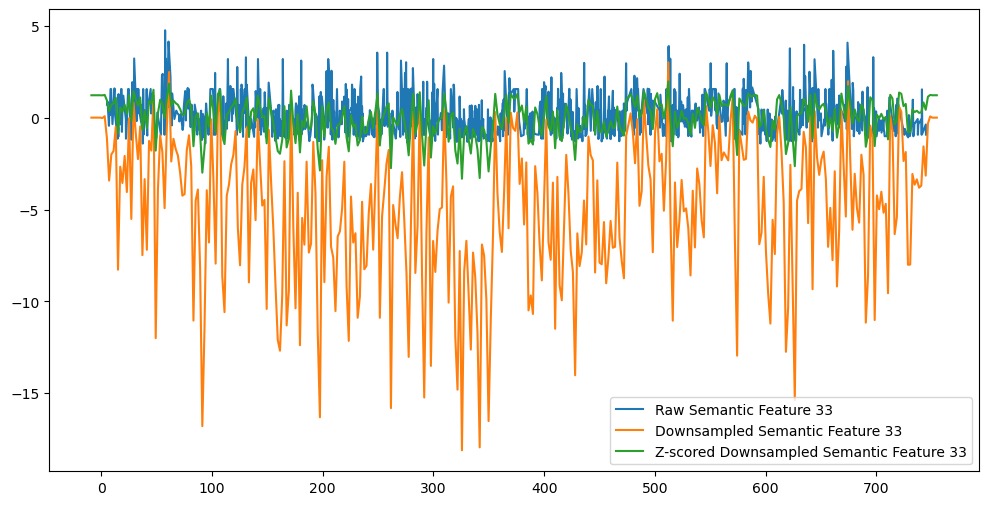

In [15]:
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
# check their raw and downsampled  values
raw_sem = zscore(semanticseqs['avatar'].data[:,33])
down_sem_all = semanticseqs['avatar'].chunksums(interptype, window=window)
down_sem = down_sem_all[:,33]
# zscore down_sem
down_sem_zscored = zscore(down_sem)
plt.figure(figsize=(12,6))
plt.plot(wordseqs['avatar'].data_times, raw_sem, label='Raw Semantic Feature 33')
plt.plot(wordseqs['avatar'].tr_times, down_sem, label='Downsampled Semantic Feature 33')
plt.plot(wordseqs['avatar'].tr_times, down_sem_zscored, label='Z-scored Downsampled Semantic Feature 33')
plt.plot()
plt.legend()

Since the Lanczos interpolation in this code repo sums across words within a TR, it can create a strong correlation between the downsampled feature and the word and phoneme rates. If the baseline of the downsampled feature is positive, the correlation is positive. If the baseline of downsampled feature is negative, the correlation is negative. As a proof of concept, I use the Lanczos function in the repo and demonstrate the downsampling effect through correlation between word or phoneme rate and semantic features. After downsampling, their correlations are high.

1839 1839
6068 6068


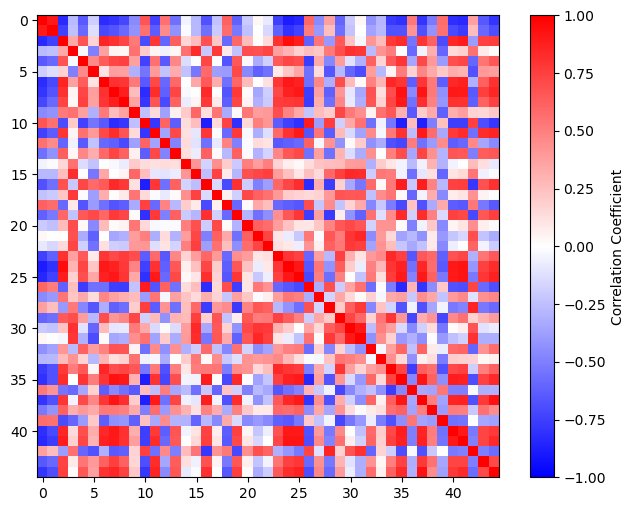

In [16]:

word_rate_seqs = wordseqs
print(len(word_rate_seqs['wheretheressmoke'].data),len(wordseqs['wheretheressmoke'].data))
word_rate_seqs['wheretheressmoke'].data = np.expand_dims(np.ones_like(wordseqs['wheretheressmoke'].data,dtype=float), axis=1)
word_rate = word_rate_seqs['wheretheressmoke'].chunksums()
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}
phoneme_rate = phonseqs
print(len(phoneme_rate['wheretheressmoke'].data),len(phonseqs['wheretheressmoke'].data))
phoneme_rate['wheretheressmoke'].data = np.expand_dims(np.ones_like(phonseqs['wheretheressmoke'].data,dtype=float), axis=1)
phoneme_rate = phoneme_rate['wheretheressmoke'].chunksums()
Pstim_nozscore = np.vstack([downsampled_semanticseqs[story] for story in Pstories])
# concatenate word rate, phoneme rate, and Pstim_nozscore without trimming
all_feat_mat = np.hstack([word_rate, phoneme_rate, Pstim_nozscore])
# correlate features in all_feat_mat
Pstim_corr = np.corrcoef(all_feat_mat, rowvar=False)
plt.figure(figsize=(8,6)) 
plt.imshow(Pstim_corr[:45,:45], cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')

To avoid creating the strong correlation with word and phoneme rates and to focus on the deviation from the expected surprisal, we z-scored surprisal within each story. Now we check the correlation between surprisal and other features.

c:\Users\ou000036\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ou000036\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\ou000036\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ou000036\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\ou000036\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ou000036\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value e

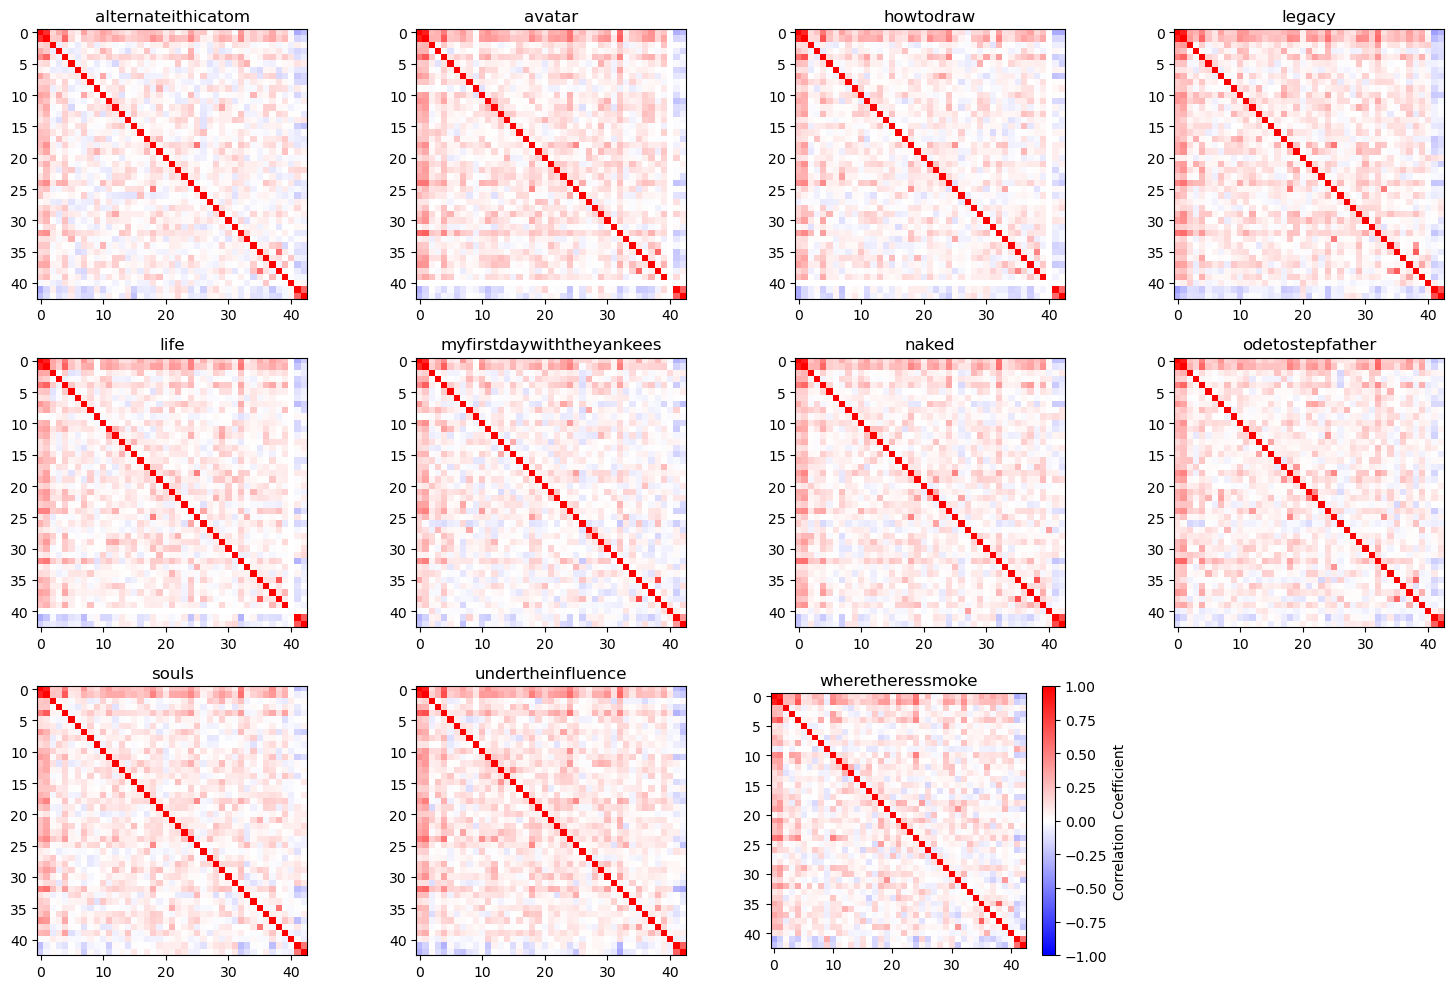

In [17]:
# for each story, plot correlation between all features including surprisal
plt.figure(figsize=(15,10))
for story in allstories:
    word_output_path = os.path.join(output_dir, f'{story}_low_level_features_surprisal_zscore.csv')
    df = pd.read_csv(word_output_path)
    feat_mat = df.to_numpy()
    feat_corr = np.corrcoef(feat_mat, rowvar=False)
    plt.subplot(3,4,allstories.index(story)+1)
    plt.imshow(feat_corr, cmap='bwr', vmin=-1, vmax=1)
    # 
    plt.title(f'{story}')
# plt.subplot(3,4,12)
plt.colorbar(label='Correlation Coefficient')
plt.tight_layout()
    

## Compare semantic features in the data repo and in the code repo

Since both repos provided the 985 semantic features, let's cross-check if features from the two sources are consistent.

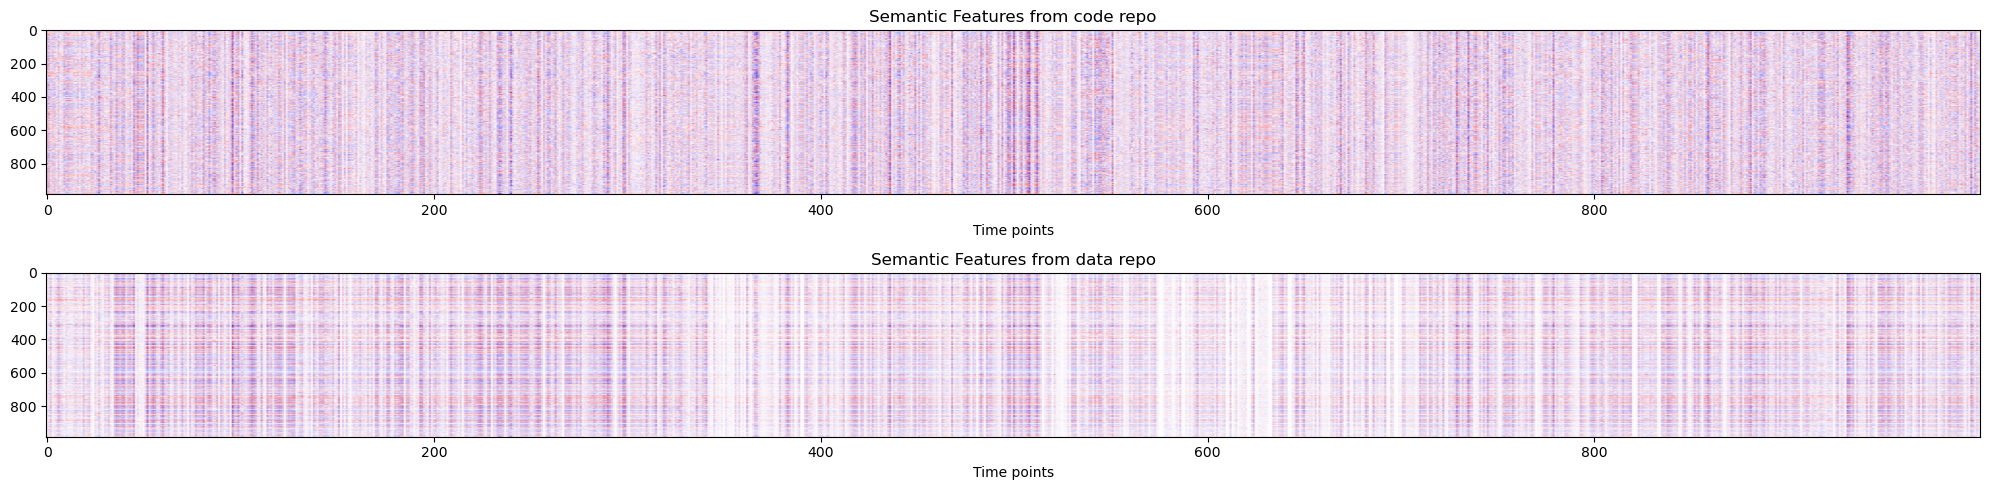

In [18]:
# compare features from the code repo and from the data repo
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.imshow(Rstim[:1000, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
plt.xlabel('Time points')
plt.title('Semantic Features from code repo')
plt.subplot(2,1,2)
plt.imshow(hdf_feat_mat['/semantic_train'][:1000, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
plt.xlabel('Time points')
plt.title('Semantic Features from data repo')
plt.tight_layout()
plt.show()

They don't match! Why not? Possibly because of different z-scoring procedures. In the tutorial, features were z-scored per story. In the data repo, it is unclear what type of z-scoring was used. However, we can always re-z-score within each story. 

After z-scoring, we make delays. See description in the paper:
"A separate linear temporal filter with four delays (1, 2, 3, and 4 time points) was fit for each of these 1,026 features, yielding a total of 4,104 features. This was accomplished by concatenating feature vectors that had been delayed by 1, 2, 3, and 4 time points (2, 4, 6, and 8s). Thus, in the concatenated feature space one channel represents the word rate 2 s earlier, another 4 s earlier, and so on. Taking the dot product of this concatenated feature space with a set of linear weights is functionally equivalent to convolving the original stimulus vectors with linear temporal kernels that have non-zero entries for 1-, 2-, 3-, and 4-time-point delays. "

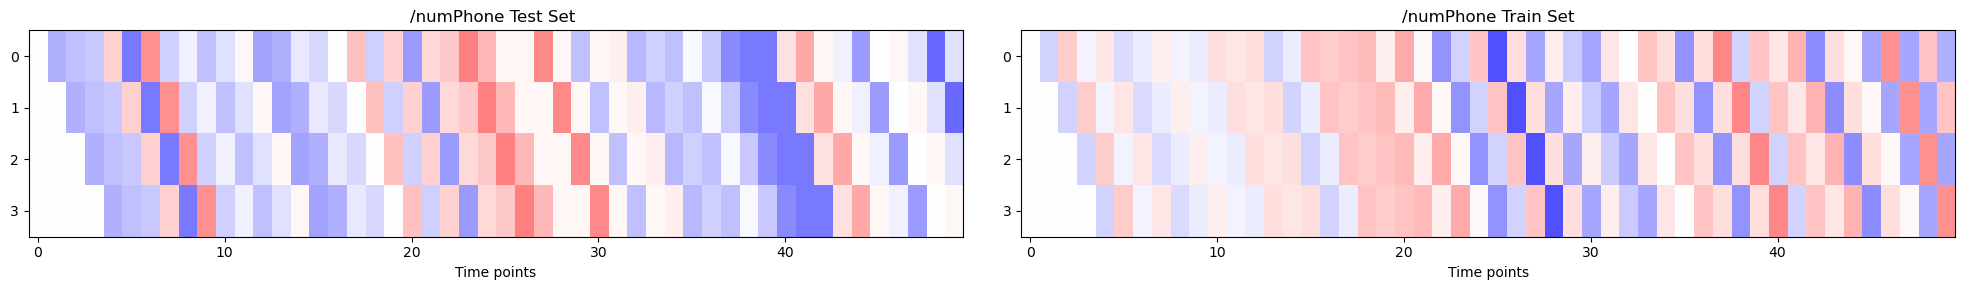

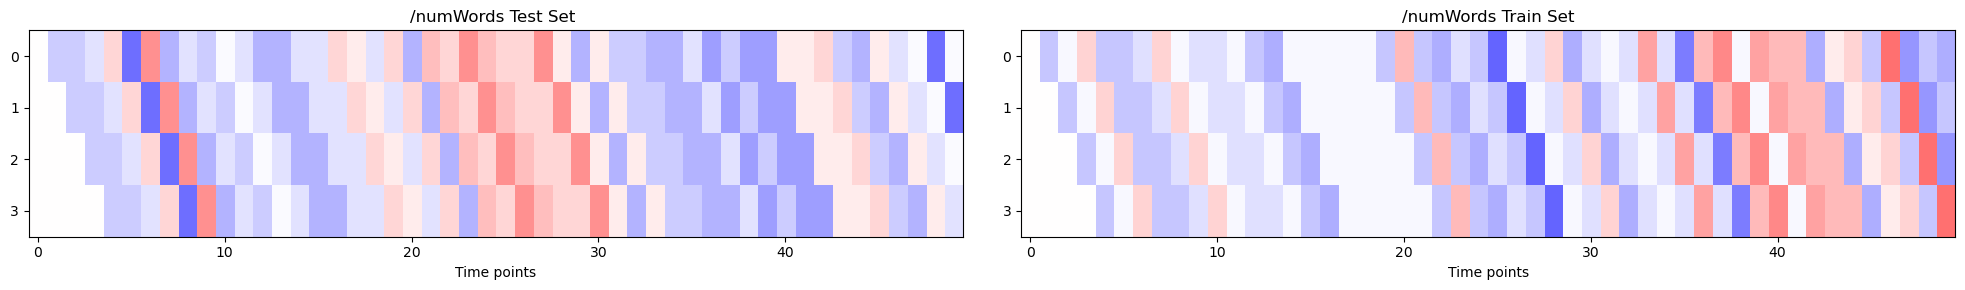

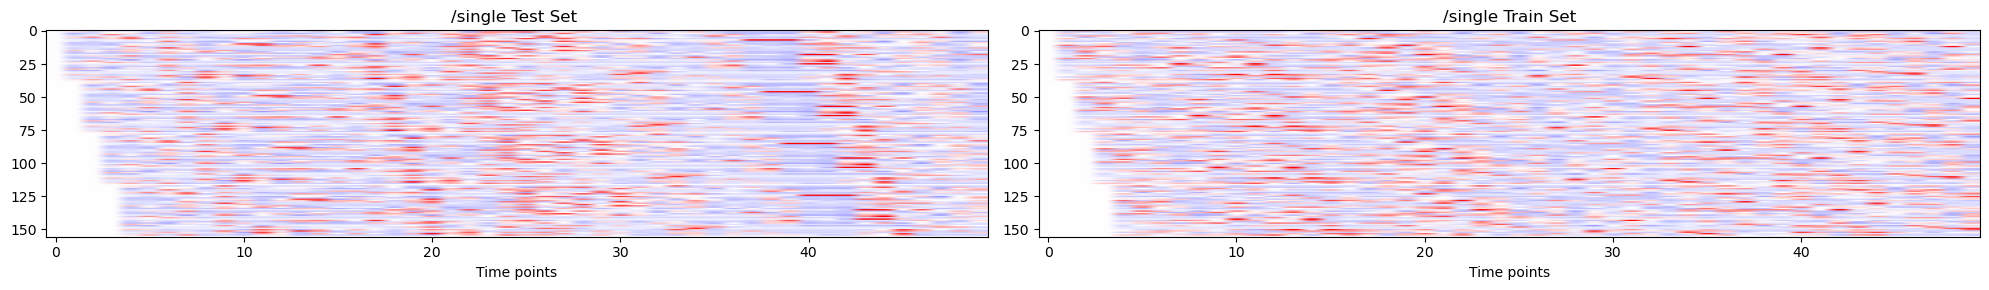

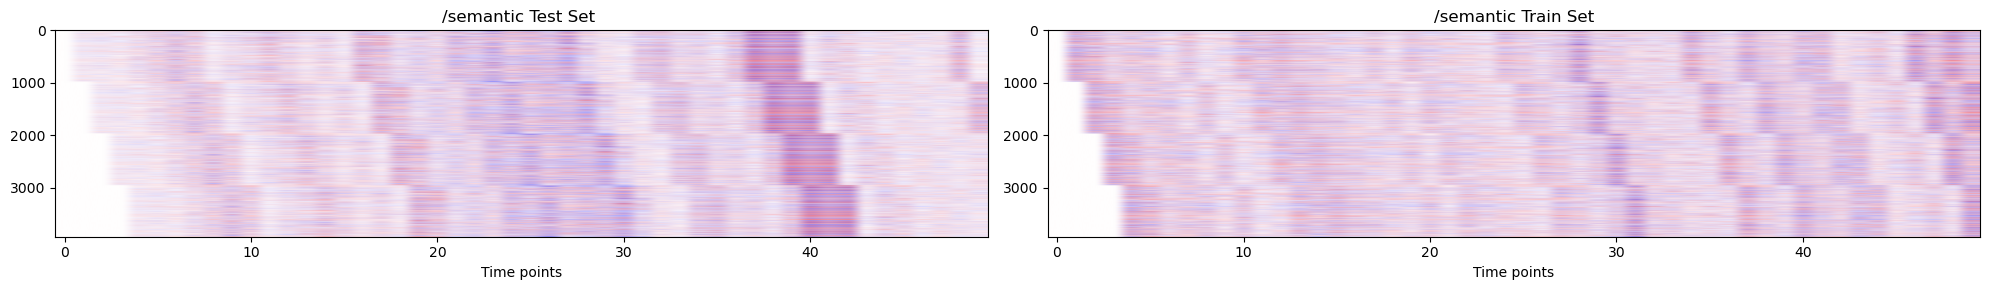

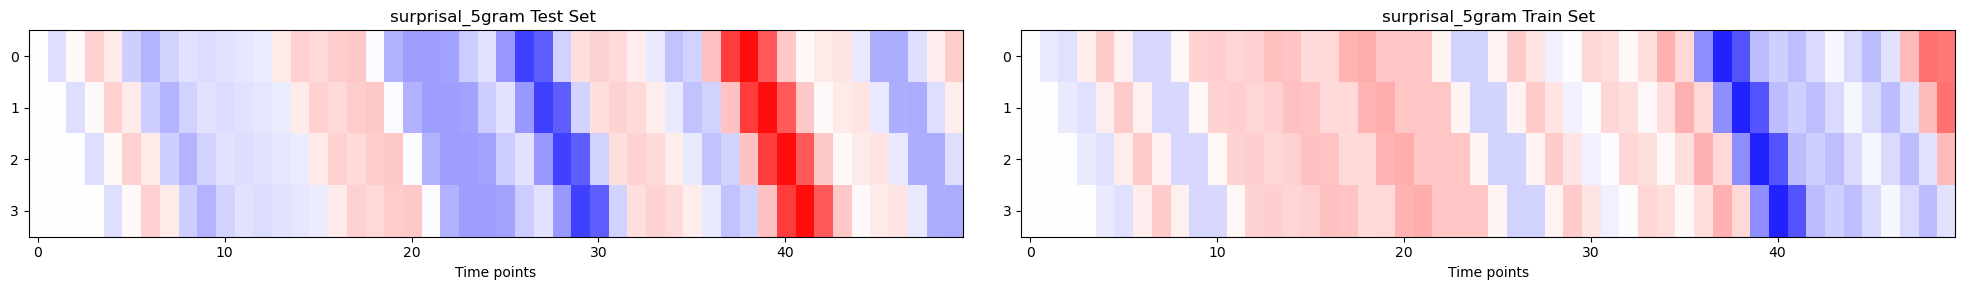

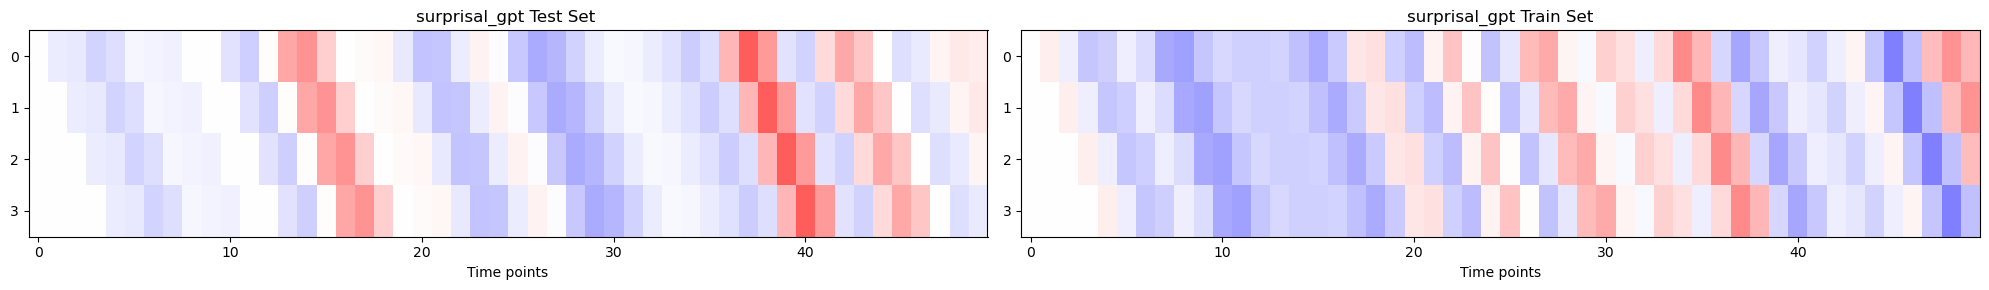

In [19]:
# We can use story boundaries to z-score Rstim properly and make FIR features

from util import make_delayed
ndelays = 4
delays = range(1, ndelays+1)

# add surprisal features to feat_list
feat_list = {'/numPhone':1, '/numWords':1, '/single':39, '/semantic':985,'surprisal_5gram':1, 'surprisal_gpt':1}
feat_delayed_train = []
feat_delayed_test = []
feat_idx = 0
for feat_name in feat_list:
    if feat_name in ['surprisal_5gram', 'surprisal_gpt']:
        zscored_feat_mat_train = np.zeros((hdf_feat_mat['/numPhone_train'].shape[0], 1))
        for story in Rstories:
            start_idx, end_idx = story_boundaries[story]
            # load from csv
            df = pd.read_csv(f'data\\surprisal\\{story}_low_level_features_surprisal_zscore.csv')
            zscored_feat_mat_train[start_idx:end_idx, 0] = df.to_numpy()[:, -2 if feat_name=='surprisal_5gram' else -1]
        # load test set
        df = pd.read_csv(f'data\\surprisal\\{Pstories[0]}_low_level_features_surprisal_zscore.csv')
        zscored_feat_mat_test = np.expand_dims(df.to_numpy()[:, -2 if feat_name=='surprisal_5gram' else -1], axis=1)
        
        feat_delayed_train.append(make_delayed(zscored_feat_mat_train, delays))
        feat_delayed_test.append(make_delayed(zscored_feat_mat_test, delays))
    else:
        # z-score each story separately for train set
        zscored_feat_mat_train = np.zeros_like(hdf_feat_mat[feat_name+"_train"])
        for story in Rstories:
            start_idx, end_idx = story_boundaries[story]
            # zscore across time points for each feature
            X = hdf_feat_mat[feat_name + "_train"][start_idx:end_idx, :]
            mu = X.mean(axis=0)
            sigma = X.std(axis=0)
            sigma[sigma == 0] = 1.0
            Xz = (X - mu) / sigma
            zscored_feat_mat_train[start_idx:end_idx, :] = Xz
        feat_delayed_train.append(make_delayed(zscored_feat_mat_train, delays))
        # for test set, just z-score across all time points
        X = hdf_feat_mat[feat_name + "_test"]
        mu = X.mean(axis=0)
        sigma = X.std(axis=0)
        sigma[sigma == 0] = 1.0
        Xz = (X - mu) / sigma
        zscored_feat_mat_test = Xz
        feat_delayed_test.append(make_delayed(zscored_feat_mat_test, delays))
    if feat_name == '/semantic':
        zscored_semantic_train = zscored_feat_mat_train
        zscored_semantic_test = zscored_feat_mat_test
    # plot the appended delayed features for the first 10 features
    plt.figure(figsize=(20,3))
    plt.subplot(1,2,1) 
    plt.imshow(feat_delayed_test[-1][:50, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
    plt.xlabel('Time points')
    plt.title(f'{feat_name} Test Set ')
    plt.subplot(1,2,2)
    plt.imshow(feat_delayed_train[-1][:50, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
    plt.xlabel('Time points')
    plt.title(f'{feat_name} Train Set')
    plt.tight_layout()
plt.tight_layout()

feat_delayed_train = np.hstack(feat_delayed_train)
feat_delayed_test = np.hstack(feat_delayed_test)

# Why does the train set has a smaller range of values than the test set?

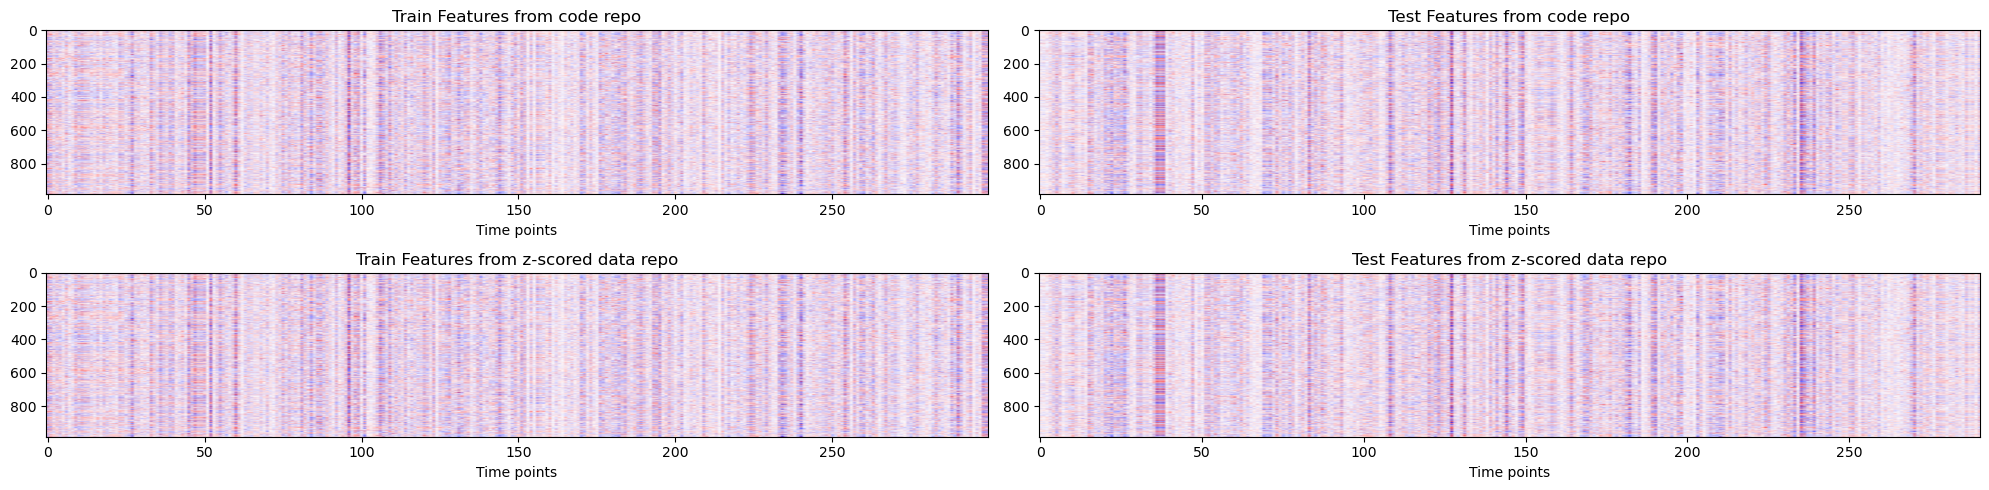

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.imshow(Rstim[:300, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
plt.xlabel('Time points')
plt.title('Train Features from code repo')
plt.subplot(2,2,3)
plt.imshow(zscored_semantic_train[:300, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
plt.xlabel('Time points')
plt.title('Train Features from z-scored data repo')
plt.subplot(2,2,2)
plt.imshow(Pstim[:300, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
plt.xlabel('Time points')
plt.title('Test Features from code repo')
plt.subplot(2,2,4)
plt.imshow(zscored_semantic_test[:300, :].T, aspect='auto', cmap='bwr', clim=(-4, 4))
plt.xlabel('Time points')
plt.title('Test Features from z-scored data repo')
plt.tight_layout()
plt.show()



In [24]:
# check value difference

print(f'Absolute mean difference between zscored semantic train and tutorial train: {np.mean(np.abs(zscored_semantic_train - Rstim))}')
print(f'Absolute mean difference between zscored semantic test and tutorial test: {np.mean(np.abs(zscored_semantic_test - Pstim))}')

# correlation between zscored_semantic_train and Rstim
corr_feat = np.corrcoef(zscored_semantic_train.flatten(), Rstim.flatten())
print(f'Correlation between zscored semantic train set and tutorial semantic train set: {corr_feat[0,1]}')
# correlation between zscored_semantic_test and Pstim
corr_feat_test = np.corrcoef(zscored_semantic_test.flatten(), Pstim.flatten())
print(f'Correlation between zscored semantic test set and tutorial semantic test set: {corr_feat_test[0,1]}')

# Now they pretty much match!

Absolute mean difference between zscored semantic train and tutorial train: 0.003742577444556672
Absolute mean difference between zscored semantic test and tutorial test: 6.540180172622886e-16
Correlation between zscored semantic train set and tutorial semantic train set: 0.9995143634785681
Correlation between zscored semantic test set and tutorial semantic test set: 1.0


In [ ]:
# export the whole delayed feature matrices to csv for later use
with open('data\\features\\delayed_feature_matrix_train.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # header
    header = []
    for feat_name, n_feat in feat_list.items():
        for delay in delays:
            for i in range(n_feat):
                header.append(f'{feat_name}_delay{delay}_feat{i}')
    writer.writerow(header)
    # data rows
    for row in feat_delayed_train:
        writer.writerow(row)
with open('data\\features\\delayed_feature_matrix_test.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # header
    header = []
    for feat_name, n_feat in feat_list.items():
        for delay in delays:
            for i in range(n_feat):
                header.append(f'{feat_name}_delay{delay}_feat{i}')
    writer.writerow(header)
    # data rows
    for row in feat_delayed_test:
        writer.writerow(row)

# Load and inspect fMRI data


In [27]:
# Check file lists
response_files = get_filelist(Path('data\\responses'))
mapper_files = get_filelist(Path('data\\mappers'))
n_subj = len(response_files)-1  # one response file is simulation
if len(mapper_files) != n_subj:
    print('Numbers of BOLD and mapper files do not correspond!')
else:
    print('Numbers of BOLD and mapper files correspond.')

Found 12 files in data\responses:
S01_BOLD.hdf
S02_BOLD.hdf
S03_BOLD.hdf
S04_BOLD.hdf
S05_BOLD.hdf
S06_BOLD.hdf
S07_BOLD.hdf
S08_BOLD.hdf
S09_BOLD.hdf
S10_BOLD.hdf
S11_BOLD.hdf
simulation_BOLD.hdf
Found 11 files in data\mappers:
AH_mappers.hdf
AN_mappers.hdf
BG_mappers.hdf
DS_mappers.hdf
JG_mappers.hdf
ML_mappers.hdf
NNS0_mappers.hdf
SP_mappers.hdf
SS_mappers.hdf
TZ_mappers.hdf
WH_mappers.hdf
Numbers of BOLD and mapper files correspond.


According to methods, the BOLD dataset went through: 
- Motion correction: All aligned with the averaged volume of the first run. 
- Low-frequency drift correction
- Within-voxel z-scoring across time points in a run

Supplementary material description:
"fMRI data pre-processing. Each functional run was motion-corrected using the FMRIB Linear Image Registration Tool (FLIRT) from FSL 5.0 (Jenkinson & Smith, 2001). All volumes in the run were then averaged to obtain a high quality template volume. FLIRT was then used to automatically align the template volume for each run to the overall template, which was chosen to be the template for the first functional run for each subject. These automatic alignments were manually checked and adjusted as necessary to improve accuracy. The cross-run transformation matrix was then concatenated to the motion-correction transformation matrices, and the concatenated transformation was used to resample the original data directly into the overall template space.  Low-frequency voxel response drift was identified using a 2nd order Savitsky-Golay filter with a 120second window and then subtracted from the signal. The mean response for each voxel was then subtracted and the remaining response was scaled to have unit variance."

Loading file:data\responses\S02_BOLD.hdf
h5py top-level groups: ['zPresp', 'zRresp']
Loaded dataset /zPresp shape=(291, 73023) dtype=float64
Loaded dataset /zRresp shape=(3737, 73023) dtype=float64
Loaded keys: ['/zPresp', '/zRresp']
Train response shape: (3737, 73023)
Test response shape: (291, 73023)


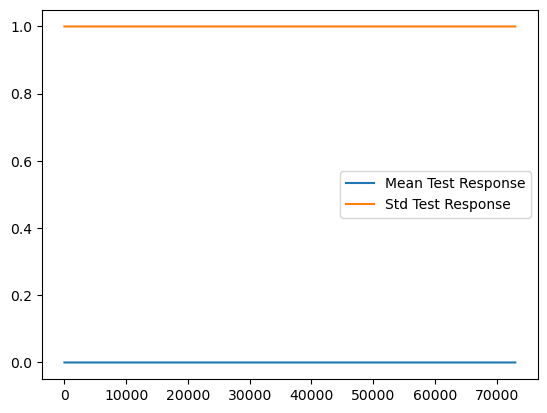

In [18]:
# Load an example dataset
subj_id = 1  
hdf_response = load_hdf_all(f'data\\responses\\S{subj_id+1:02d}_BOLD.hdf')

# Examine how data were z-scored
train_response = hdf_response['/zRresp']  # shape: n_timepoints x n_voxels
test_response = hdf_response['/zPresp']  # shape: n_timepoints x n_voxels
print(f'Train response shape: {train_response.shape}')
print(f'Test response shape: {test_response.shape}')
plt.plot(np.mean(test_response, axis=0))
plt.plot(np.std(test_response, axis=0))
plt.legend(['Mean Test Response', 'Std Test Response'])

In [ ]:
# Examine response distributions
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.hist(test_response.flatten(), bins=50)
plt.title('Test set response distributions for Subject ' + str(subj_id))
plt.subplot(2, 2, 2)
plt.hist(train_response.flatten(), bins=50)
plt.title('Train set response distributions for Subject ' + str(subj_id))
plt.subplot(2, 2, 3)
plt.imshow(test_response[:,20000:22000],cmap='bwr',clim=(-3, 3))
plt.subplot(2, 2, 4)
plt.imshow(train_response[:,20000:22000],cmap='bwr',clim=(-3, 3))
plt.tight_layout()
plt.show()

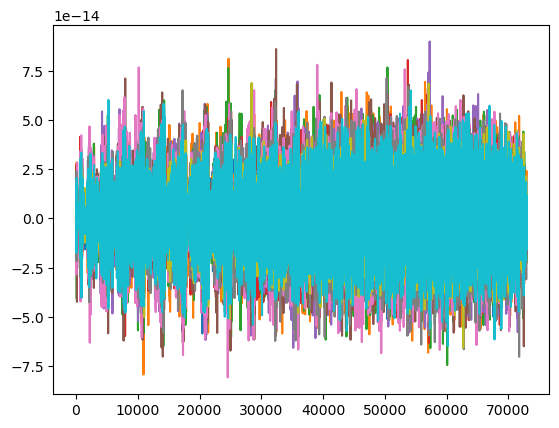

In [ ]:
# Are they z-scored within stories?
for story in Rstories:
    train_per_story = train_response[story_boundaries[story][0]:story_boundaries[story][1]]
    plt.plot(np.mean(train_per_story, axis=0))

# Yes they are.
   

Therefore, these fMRI data were runwise z-scored.

## Check noise ceiling
Here we load multiple repetitions of the test data. We want to see if they match the averaged response provided in the original data repository.

In [20]:
npz_file = np.load(f'data\\responses\\test_rep\\S{subj_id+1:02d}_test_rep.npz')
print(f'Rep data shape: {npz_file["wheretheressmoke"].shape}')

Rep data shape: (2, 291, 73023)


Data dimensions are (repetitions, TRs, voxels). Some subjects have more than 2 repetitions.

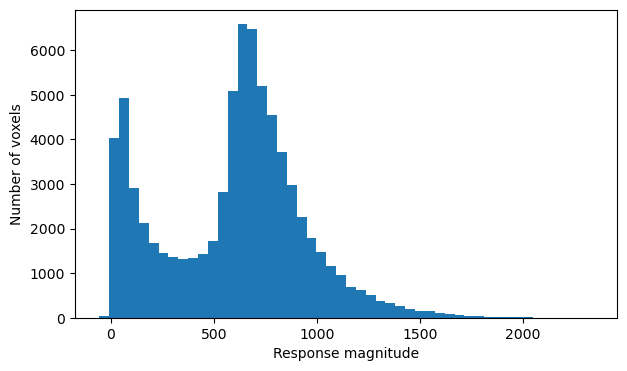

In [21]:
meanbeta = np.mean(npz_file['wheretheressmoke'], axis=(0, 1))
plt.figure(figsize=(7, 4))
plt.hist(meanbeta.flatten(), bins=50)
plt.xlabel('Response magnitude')
plt.ylabel('Number of voxels')
plt.show()

Apparently, these data were not z-scored!  Let's try to z-score them and see if they match the averaged test data.

In [22]:
import scipy
# z-score test response within each voxel

# first average across repetitions
avg_rep = np.nanmean(npz_file['wheretheressmoke'], axis=0)
# then z-score
z_scores_avg_rep = scipy.stats.zscore(avg_rep, axis=0)

# first z-score within each voxel across TRs
z_scores_rep = scipy.stats.zscore(npz_file['wheretheressmoke'], axis=1) 
# then average across repetitions
avg_z_scores_rep = np.nanmean(z_scores_rep, axis=0)

C:\Users\ou000036\AppData\Local\Temp\ipykernel_25528\3051893128.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores_rep = scipy.stats.zscore(npz_file['wheretheressmoke'], axis=1)


See by eyeball, which z-score method is more likely the one they used?

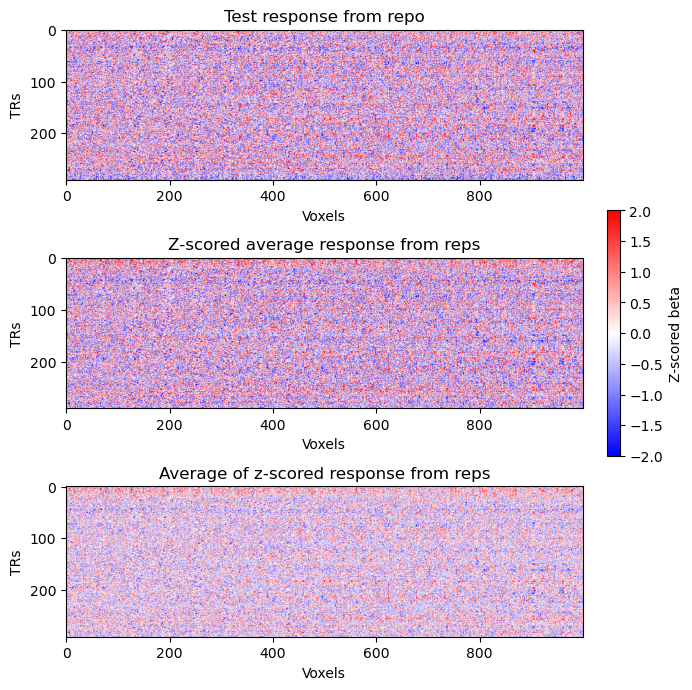

In [32]:
plt.figure(figsize=(7, 7))
plt.subplot(3,1,1)
plt.imshow(test_response[:,9000:10000], cmap='bwr', clim=(-2, 2))
plt.ylabel('TRs')
plt.xlabel('Voxels')
plt.title('Test response from repo')
plt.subplot(3,1,2)
plt.imshow(z_scores_avg_rep[:,9000:10000], cmap='bwr', clim=(-2, 2))
plt.ylabel('TRs')
plt.xlabel('Voxels')
plt.title('Z-scored average response from reps')
plt.subplot(3,1,3)
plt.imshow(avg_z_scores_rep[:,9000:10000], cmap='bwr', clim=(-2, 2))
plt.title('Average of z-scored response from reps')
plt.ylabel('TRs')
plt.xlabel('Voxels')
plt.tight_layout()
# add colorbar for all subplots
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-2, vmax=2)), ax=plt.gcf().get_axes(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Z-scored beta')

plt.show()

Now check correlation between the two versions of test data. Also, we compute the noise ceiling by correlating the two repetitions. They are super low!

In [33]:
# number of nans in test_response
print(f'Number of NaNs in test response: {np.isnan(test_response[0,:]).sum()}')
# number of nans in z_scores_avg_rep
print(f'Number of NaNs in z_scores_avg_rep: {np.isnan(z_scores_avg_rep[0,:]).sum()}')
print(f'Number of NaNs in z_scores_rep 1: {np.isnan(z_scores_rep[0,0,:]).sum()}')
print(f'Number of NaNs in z_scores_rep 2: {np.isnan(z_scores_rep[1,0,:]).sum()}')
# get rid of nans in arrays
mask = ~np.isnan(test_response[0,:]) & ~np.isnan(z_scores_avg_rep[0,:]) & ~np.isnan(z_scores_rep[0,0,:]) & ~np.isnan(z_scores_rep[1,0,:]) 
clean_test_response = test_response[:,mask]
clean_z_scores_avg_rep = z_scores_avg_rep[:,mask]
clean_z_scores_rep = z_scores_rep[:, :, mask]
clean_avg_z_scores_rep = avg_z_scores_rep[:,mask]

# compute correlation between clean_test_response and clean_z_scores_avg_rep
from scipy.stats import pearsonr
correlations = pearsonr(clean_test_response.flatten(), clean_z_scores_avg_rep.flatten())[0]
print(f'Correlation between test response and z-scored average response: {correlations}')
correlations = pearsonr(clean_test_response.flatten(), clean_avg_z_scores_rep.flatten())[0]
print(f'Correlation between test response and average of z-scored response: {correlations}')
for reps in range(clean_z_scores_rep.shape[0]):
    rep_corr = pearsonr(clean_test_response.flatten(), clean_z_scores_rep[reps,:,:].flatten())[0]
    print(f'Correlation for repetition {reps+1}: {rep_corr}')

# compute noise ceiling between two repetitions for each voxel
noise_ceiling = []
for v in range(z_scores_rep.shape[2]):
    rep1 = z_scores_rep[0,:,v]
    rep2 = z_scores_rep[1,:,v]
    valid_mask = ~np.isnan(rep1) & ~np.isnan(rep2)
    if np.sum(valid_mask) > 0:
        corr = pearsonr(rep1[valid_mask], rep2[valid_mask])[0]
        noise_ceiling.append(corr)
    else:
        noise_ceiling.append(np.nan)

Number of NaNs in test response: 0
Number of NaNs in z_scores_avg_rep: 0
Number of NaNs in z_scores_rep 1: 0
Number of NaNs in z_scores_rep 2: 54
Correlation between test response and z-scored average response: 0.02022353786941587
Correlation between test response and average of z-scored response: 0.01944439680570942
Correlation for repetition 1: 0.006048633122681839
Correlation for repetition 2: 0.022057904299861115


In [ ]:
# Let's save all subject's noise ceiling data
for subj_id in range(n_subj):
    npz_file = np.load(f'data\\responses\\test_rep\\S{subj_id+1:02d}_test_rep.npz')
    z_scores_rep = scipy.stats.zscore(npz_file['wheretheressmoke'], axis=1) 
    noise_ceiling = []
    for v in range(z_scores_rep.shape[2]):
        rep1 = z_scores_rep[0,:,v]
        rep2 = z_scores_rep[1,:,v]
        valid_mask = ~np.isnan(rep1) & ~np.isnan(rep2)
        if np.sum(valid_mask) > 0:
            corr = pearsonr(rep1[valid_mask], rep2[valid_mask])[0]
            noise_ceiling.append(corr)
        else:
            noise_ceiling.append(np.nan)
    noise_ceiling = np.array(noise_ceiling)
    np.savez(f'results\\S{subj_id+1:02d}_noise_ceiling.npz', noise_ceiling=noise_ceiling)
    

C:\Users\ou000036\AppData\Local\Temp\ipykernel_21968\3289052419.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores_rep = scipy.stats.zscore(npz_file['wheretheressmoke'], axis=1)
C:\Users\ou000036\AppData\Local\Temp\ipykernel_21968\3289052419.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores_rep = scipy.stats.zscore(npz_file['wheretheressmoke'], axis=1)
C:\Users\ou000036\AppData\Local\Temp\ipykernel_21968\3289052419.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores_rep = scipy.stats.zscore(npz_file['wheretheressmoke'], axis=1)
C:\Users\ou000036\AppData\Local\Temp\ipykernel_21968\32

How about the difference between test_response and z_scores_avg_rep?

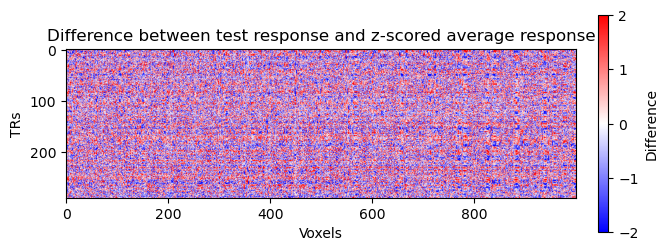

In [ ]:

plt.figure(figsize=(7, 10))
plt.imshow(test_response[:,40000:41000] - z_scores_avg_rep[:,40000:41000], cmap='bwr', clim=(-2, 2))
plt.ylabel('TRs')
plt.xlabel('Voxels')
plt.title('Difference between test response and z-scored average response')
# adjust the size of the colorbar
plt.colorbar(plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-2, vmax=2)), ax=plt.gcf().get_axes(), orientation='vertical', fraction=0.02, pad=0.04, label='Difference')
plt.show()

No pattern at all!

Anyway, let's use the averaged test data first.

# Fitting weight matrix to response and evaluate
"The 4,104 weights for each voxel were estimated using L2-regularized linear regression (also known as ridge regression). To keep the scale of the weights consistent and to prevent bias in subsequent analyses, a single value of the regularization coefficient was used for all voxels in all subjects. This regularization coefficient was found by bootstrapping the regression procedure 50 times in each subject. In each bootstrap iteration, 800 time points (20 blocks of 40 consecutive time points each) were removed from the model estimation data set and reserved for testing. Then the model weights were estimated on the remaining 2,937 time points for each of 20 possible regularization coefficients (log spaced between 10 and 1,000). These weights were used to predict responses for the 800 reserved time points, and then the correlation between actual and predicted responses was found. 

After the bootstrapping was complete, a regularization–performance curve was obtained for each subject by averaging the bootstrap sample correlations first across the 50 samples and then across all voxels. Next, the regularization–performance curves were averaged across the seven subjects and the best overall value of the regularization parameter (183.3) was selected. The best overall regularization parameter value was also the best value in three individual subjects. For the other four subjects the best regularization parameter value was slightly higher (233.6)"
 
I used 183.3 directly, as the bootstrapping takes forever...

In [ ]:
# # this code is flawed because it doesn't deal with blocks (20 blocks of 40 consecutive time points each)
# from sklearn.linear_model import Ridge
# import time
# candidate_lambdas = np.logspace(1, 4, num=10)  # from 10^1 to 10^4
# n_bootstraps = 50
# n_subj = 2
# # Bootstrap in each subject to pick regularization coefficients
# lambda_corr_curve = np.zeros((n_subj, len(candidate_lambdas)))  # shape: n_subj x n_candidate_lambdas
# plt.figure(figsize=(8,6))
# for subj in range(n_subj):
#     hdf_response = load_hdf_all('responses\\' + response_files[subj])
#     train_response = hdf_response['/zRresp']  # shape: n_timepoints x n_voxels
#     test_response = hdf_response['/zPresp']  # shape: n_timepoints x n_voxels
#     # remove voxels with NaN values
#     no_nan_voxels = ~np.isnan(train_response).any(axis=0)
#     train_response = train_response[:, no_nan_voxels]
#     test_response = test_response[:, no_nan_voxels]
#     n_voxels = train_response.shape[1]
#     print(f'Subject {subj}: Train response shape: {train_response.shape}')
#     print(f'Subject {subj}: Test response shape: {test_response.shape}')
#     # bootstrap 50 times to pick lambda
#     np.random.seed(42 + subj)  # for reproducibility
#     corr_list = np.zeros((n_bootstraps, len(candidate_lambdas), n_voxels))
#     for b in range(n_bootstraps):
#         start_time = time.time()
#         # randomly pick 800 time points from the train_response 
#         rand_indices = np.random.choice(train_response.shape[0], size=800, replace=False)
#         # remove these 800 time points from train_response
#         train_minus_800_response = np.delete(train_response, rand_indices, axis=0)
#         train_800_response = train_response[rand_indices, :]
#         feat_minus_800 = np.delete(feat_delayed_train, rand_indices, axis=0)
#         feat_800 = feat_delayed_train[rand_indices, :]
        
#         # loop over candidate lambdas
#         for i, lam in enumerate(candidate_lambdas):
#             # fit ridge regression using L2 regularization 
#             ridge_model = Ridge(alpha=lam, fit_intercept=False)
#             # fit feat_minus_800 to train_minus_800_response for each voxel
#             ridge_model.fit(feat_minus_800, train_minus_800_response)
#             # predict on feat_800
#             pred_response = ridge_model.predict(feat_800)
#             # compute correlation between predicted and actual responses
#             corrs = np.array([np.corrcoef(pred_response[:, v], train_800_response[:, v])[0, 1] if np.std(pred_response[:, v]) > 0 and np.std(train_800_response[:, v]) > 0 else 0.0 for v in range(n_voxels)], dtype=np.float32)
#             corr_list[b,i,:] = corrs
#             # # compute per-voxel Pearson correlation between predicted and actual responses (memory-efficient)
#             # # pred_response and train_800_response have shape: (n_time, n_voxels)
#             # pr = pred_response.astype(np.float32, copy=False)
#             # tr = train_800_response.astype(np.float32, copy=False)
#             # pr_mean = pr.mean(axis=0)
#             # tr_mean = tr.mean(axis=0)
#             # # numerator: sum over time of (pr-mean_pr)*(tr-mean_tr) per voxel
#             # num = np.einsum('ij,ij->j', pr - pr_mean, tr - tr_mean)
#             # # denominator: sqrt(sum((pr-mean_pr)^2) * sum((tr-mean_tr)^2)) per voxel
#             # den = np.sqrt(np.sum((pr - pr_mean)**2, axis=0) * np.sum((tr - tr_mean)**2, axis=0))
#             # zero_denom = den == 0
#             # corrs = np.empty_like(num, dtype=np.float32)
#             # corrs[~zero_denom] = num[~zero_denom] / den[~zero_denom]
#             # corrs[zero_denom] = 0.0
#             # corr_list[b,i,:] = corrs
#         # calculate time elapsed for this bootstrap
#         elapsed_time = time.time() - start_time
#         print(f'Subject {subj}, Bootstrap {b} done. Time elapsed: {elapsed_time:.2f} seconds')

#     # average across 50 bootstrapped correlations and average across voxels to get regularization-performance curve
#     lambda_corr_curve[subj,:] = np.mean(corr_list, axis=(0,2))  # shape: (len(candidate_lambdas),)
#     # plot the lambda correlation curve for this subject
#     plt.plot(candidate_lambdas, lambda_corr_curve[subj,:])
#     plt.hold(True)
# avg_lambda_curve = np.mean(lambda_corr_curve, axis=0)
# plt.plot(candidate_lambdas, avg_lambda_curve, color='k', linewidth=3, label='Average across subjects')
# plt.xscale('log')
# plt.xlabel('Regularization Coefficient (Lambda)')


In [ ]:
# This code comes from the code repo's bootstrap_ridge function. I didn't use it, but technically we can use it?
# alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
# nboots = 1 # Number of cross-validation runs.
# chunklen = 40 # 
# nchunks = 20

# wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, zRresp, delPstim, zPresp,
#                                                      alphas, nboots, chunklen, nchunks,
#                                                      singcutoff=1e-10, single_alpha=True)

"To validate the voxel-wise models, estimated semantic feature weights were used to predict responses to a separate story that had not been used for weight estimation. Prediction performance was then estimated as the Pearson correlation between predicted and actual responses for each voxel over the 290 time points (**Why is it not 291???**) in the validation story. Statistical significance was computed by comparing estimated correlations to the null distribution of correlations between two independent Gaussian random vectors of the same length (**How many iterations?**). Resulting P values were corrected for multiple comparisons within each subject using the false discovery rate (FDR) procedure."

Loading file:data\responses\S03_BOLD.hdf
h5py top-level groups: ['zPresp', 'zRresp']
Loaded dataset /zPresp shape=(291, 76390) dtype=float64
Loaded dataset /zRresp shape=(3737, 76390) dtype=float64
Loaded keys: ['/zPresp', '/zRresp']
Subject 3: Train response shape: (3737, 76216)
Subject 3: Test response shape: (291, 76216)
Subject 3: feature delayed train shape: (3737, 4104)
Subject 3: Fitting Ridge regression...
Subject 3: Predicted test response shape: (291, 76216)
Shape of correlation array: (76216,)
Shape of p-values array: (76216,)
Subject 2: Number of significant voxels after FDR correction: 220 out of 76216
Subject 2: Time taken for prediction and evaluation: 36.87 seconds
Loading file:data\responses\S04_BOLD.hdf
h5py top-level groups: ['zPresp', 'zRresp']
Loaded dataset /zPresp shape=(291, 80615) dtype=float64
Loaded dataset /zRresp shape=(3737, 80615) dtype=float64
Loaded keys: ['/zPresp', '/zRresp']
Subject 4: Train response shape: (3737, 79956)
Subject 4: Test response shap

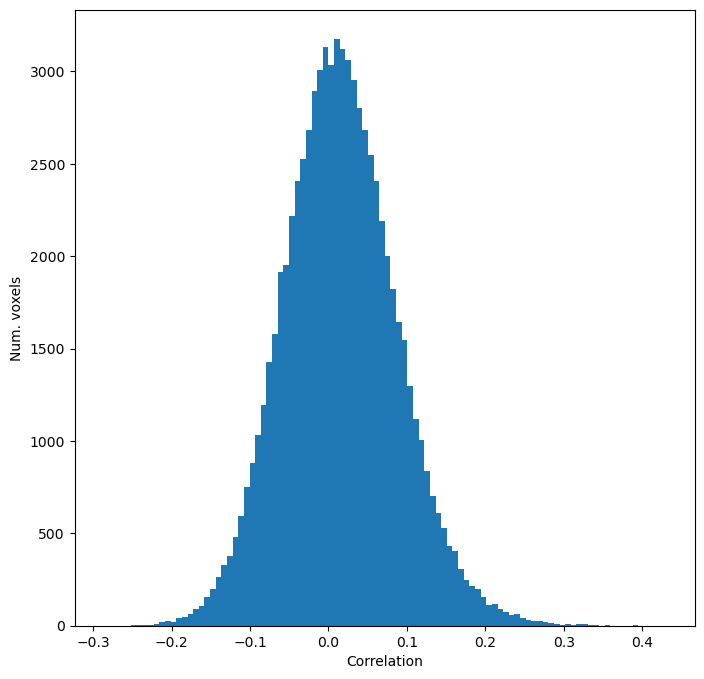

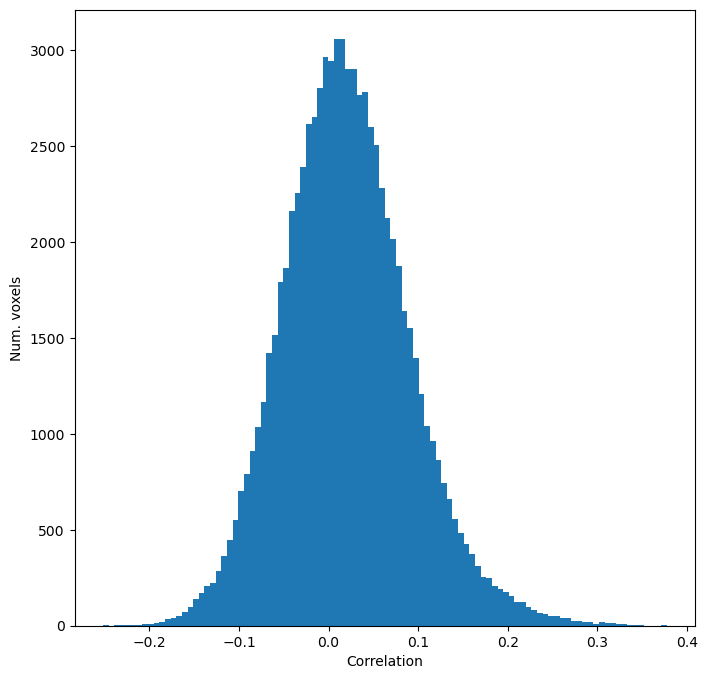

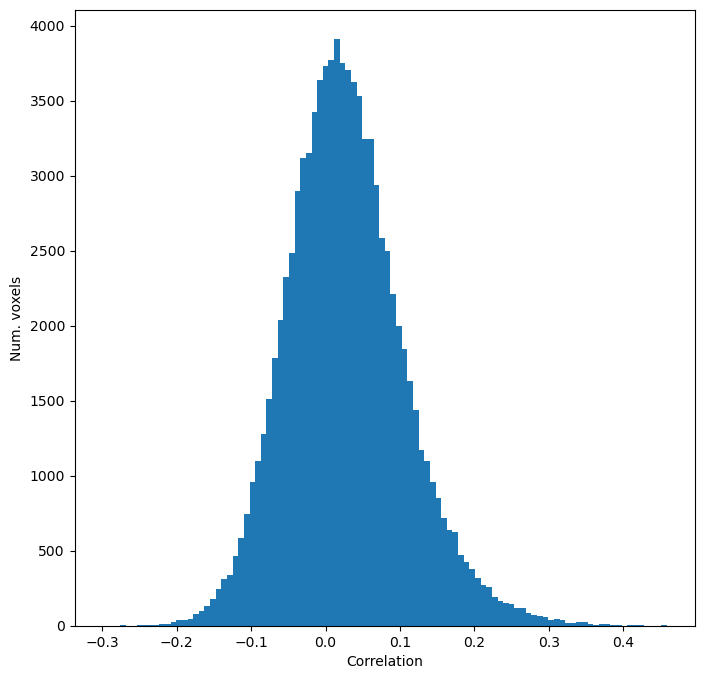

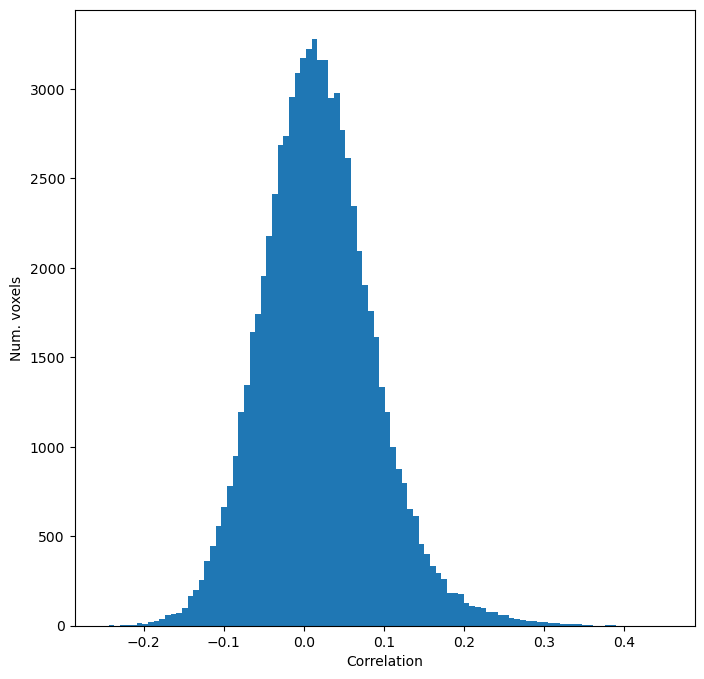

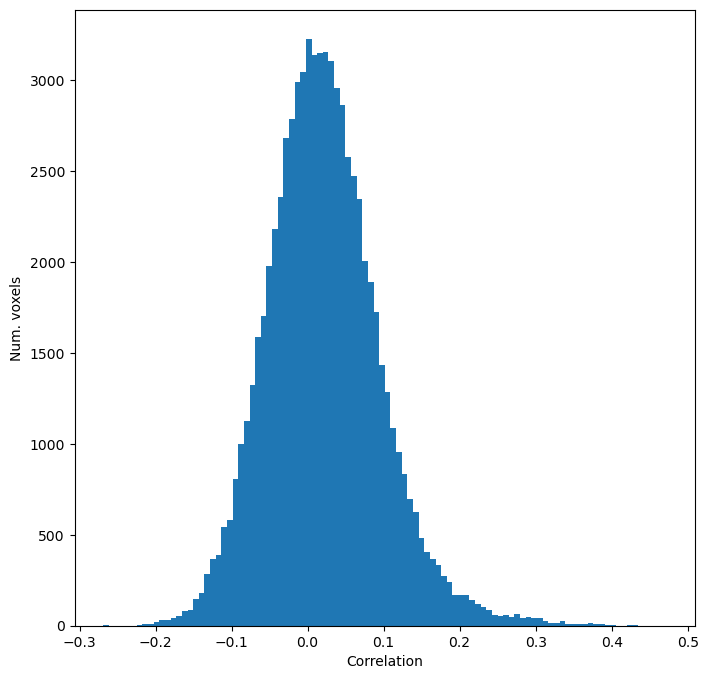

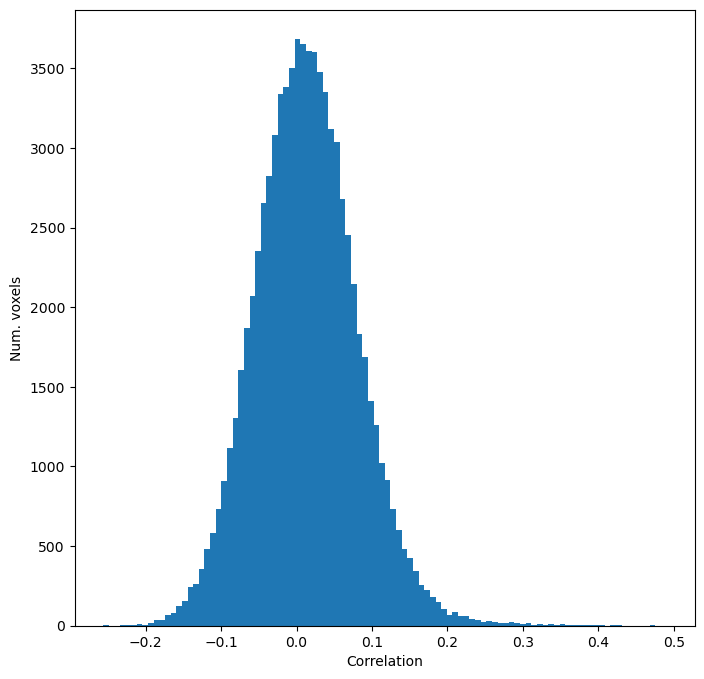

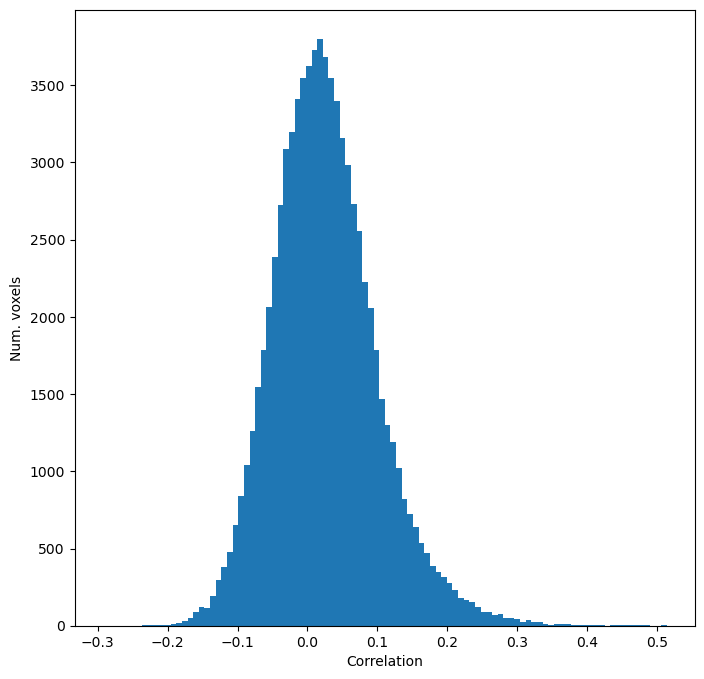

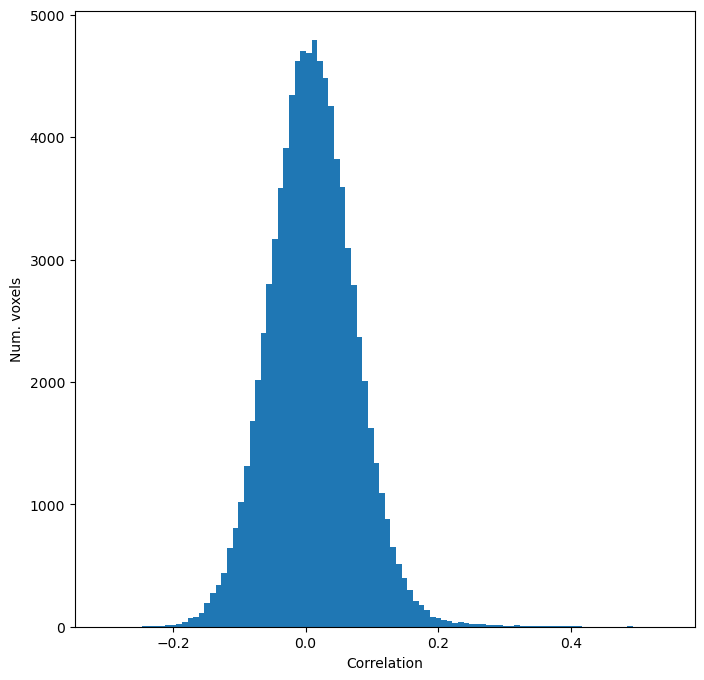

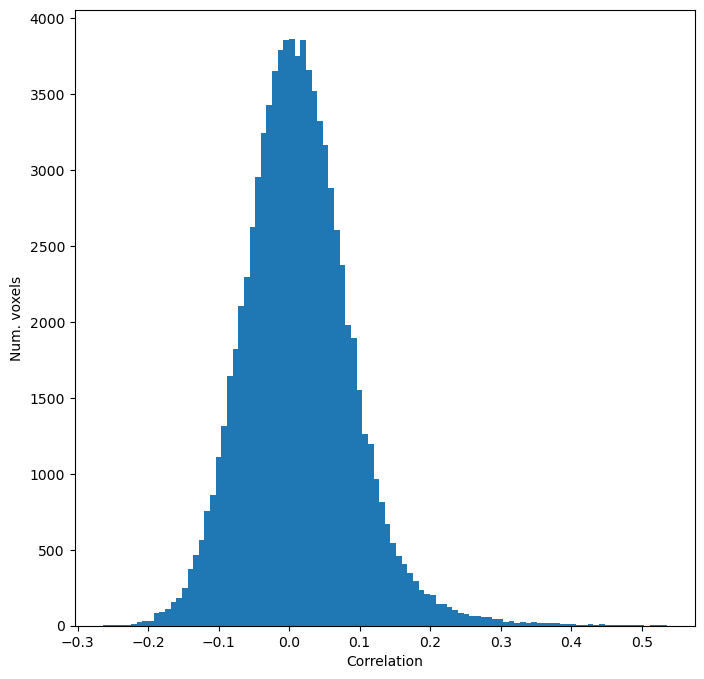

In [ ]:
import time
from sklearn.linear_model import Ridge
selected_lambda = 183.3  # paper used this

# Fit training data with selected lambda and predict on test data with Ridge regression
subj_list = range(2,11)
test_pred_responses = []
for subj in subj_list:
    start_time = time.time()
    hdf_response = load_hdf_all(f'data\\responses\\S{subj+1:02d}_BOLD.hdf')
    train_response = hdf_response['/zRresp']  # shape: n_timepoints x n_voxels
    test_response = hdf_response['/zPresp']  # shape: n_timepoints x n_voxels
    # remove voxels with NaN values
    no_nan_voxels = ~np.isnan(train_response).any(axis=0)
    # positive_voxels = np.mean(train_response, axis=0) > 0
    # no_nan_voxels = no_nan_voxels & positive_voxels
    train_response = train_response[:, no_nan_voxels]
    test_response = test_response[:, no_nan_voxels]
    n_voxels = train_response.shape[1]
    print(f'Subject {subj+1}: Train response shape: {train_response.shape}')
    print(f'Subject {subj+1}: Test response shape: {test_response.shape}')
    print(f'Subject {subj+1}: feature delayed train shape: {feat_delayed_train.shape}')

    # fit ridge regression using L2 regularization
    ridge_model = Ridge(alpha=selected_lambda, fit_intercept=False)
    print(f'Subject {subj+1}: Fitting Ridge regression...')
    ridge_model.fit(feat_delayed_train, train_response)
    # ridge_model.fit(delRstim, train_response)
    
    # predict on test set
    pred_response = ridge_model.predict(feat_delayed_test)
    # pred_response = ridge_model.predict(delPstim)
    test_pred_responses.append(pred_response)  # shape: n_timepoints x n_voxels,
    print(f'Subject {subj+1}: Predicted test response shape: {pred_response.shape}')

    # evaluate prediction performance via per-voxel Pearson correlation
    # (break down to these steps for memory efficiency)
    pr = pred_response.astype(np.float32, copy=False)
    tr = test_response.astype(np.float32, copy=False)
    pr_mean = pr.mean(axis=0)
    tr_mean = tr.mean(axis=0)
    # numerator: sum over time of (pr-mean_pr)*(tr-mean_tr) per voxel
    num = np.einsum('ij,ij->j', pr - pr_mean, tr - tr_mean)
    # denominator: sqrt(sum((pr-mean_pr)^2) * sum((tr-mean_tr)^2)) per voxel
    den = np.sqrt(np.sum((pr - pr_mean)**2, axis=0) * np.sum((tr - tr_mean)**2, axis=0))
    zero_denom = den == 0
    corrs = np.empty_like(num, dtype=np.float32)
    corrs[~zero_denom] = num[~zero_denom] / den[~zero_denom]
    corrs[zero_denom] = 0.0
    print(f'Shape of correlation array: {corrs.shape}')
    restored_corrs = np.zeros((hdf_response['/zPresp'].shape[1],), dtype=np.float32)
    restored_corrs[no_nan_voxels] = corrs

# I didn't end up using this implementation for significance values because it seems to be buggy. It gives very small numbers of significant voxels when the model generally have high correlations.
    # # --- Corrected null-distribution and p-value computation ---
    # # Use the correct number of timepoints (length of predicted/test responses)
    # n_timepoints = pred_response.shape[0]

    # # number of null draws (increase for smoother tail estimates; tradeoff speed/memory)
    # n_null = 1000
    # # vectorized null: generate n_null pairs of independent Gaussian vectors
    # rng = np.random.default_rng(42)
    # rand1 = rng.normal(size=(n_null, n_timepoints)).astype(np.float32)
    # rand2 = rng.normal(size=(n_null, n_timepoints)).astype(np.float32)

    # # compute correlation per null sample
    # num_null = np.einsum('ij,ij->i', rand1, rand2)
    # den_null = np.sqrt(np.sum(rand1**2, axis=1) * np.sum(rand2**2, axis=1))
    # zero_mask = den_null == 0
    # null_corrs = np.empty(n_null, dtype=np.float32)
    # null_corrs[~zero_mask] = num_null[~zero_mask] / den_null[~zero_mask]
    # null_corrs[zero_mask] = 0.0

    # # one-sided p-values for each voxel 
    # p_values = np.array([np.mean(v > null_corrs) for v in corrs], dtype=np.float32) 
    # print(f'Shape of p-values array: {p_values.shape}')
    # # Benjamini-Hochberg FDR: prefer statsmodels if available, fall back to manual BH
    # try:
    #     from statsmodels.stats.multitest import fdrcorrection
    #     rejected, pvals_corrected = fdrcorrection(p_values, alpha=0.05)
    #     significant_voxels = rejected
    # except Exception:
    #     sorted_p_indices = np.argsort(p_values)
    #     sorted_p_values = p_values[sorted_p_indices]
    #     fdr_level = 0.05
    #     n_tests = len(p_values)
    #     bh_thresholds = (np.arange(1, n_tests + 1) / n_tests) * fdr_level
    #     below_threshold = sorted_p_values <= bh_thresholds
    #     if np.any(below_threshold):
    #         max_index = np.max(np.where(below_threshold)[0])
    #         p_value_cutoff = sorted_p_values[max_index]
    #     else:
    #         p_value_cutoff = 0.0
    #     significant_voxels = p_values <= p_value_cutoff

    # restore to original voxel space
    restored_significant_voxels = np.zeros((hdf_response['/zPresp'].shape[1],), dtype=bool)
    # restored_significant_voxels[no_nan_voxels] = significant_voxels
    # significant_voxel_indices = np.where(restored_significant_voxels)[0]
    # n_significant = np.sum(restored_significant_voxels)
    # print(f'Subject {subj+1}: Number of significant voxels after FDR correction: {n_significant} out of {n_voxels}')

    end_time = time.time()
    print(f'Subject {subj+1}: Time taken for prediction and evaluation: {end_time - start_time:.2f} seconds')
    # Plot histogram of correlations
    f = plt.figure(figsize=(3,8))
    ax = f.add_subplot(n_subj,1,subj+1)
    ax.hist(corrs, 100) # histogram correlations with 100 bins
    ax.set_xlabel("Correlation")
    ax.set_ylabel("Num. voxels")
    ax.set_title(f"Subject {subj+1} Prediction Correlations")
    plt.show()
    # save restored_corrs and significant_voxel_indices as npz files
    # np.savez(f'results\\S{subj+1:02d}_results.npz', restored_corrs=restored_corrs, significant_voxel_indices=significant_voxel_indices)
    np.savez(f'results\\S{subj+1:02d}_results.npz', restored_corrs=restored_corrs)

        

Let's look at the noise ceiling of these super star voxels with high correlation and the other way around.

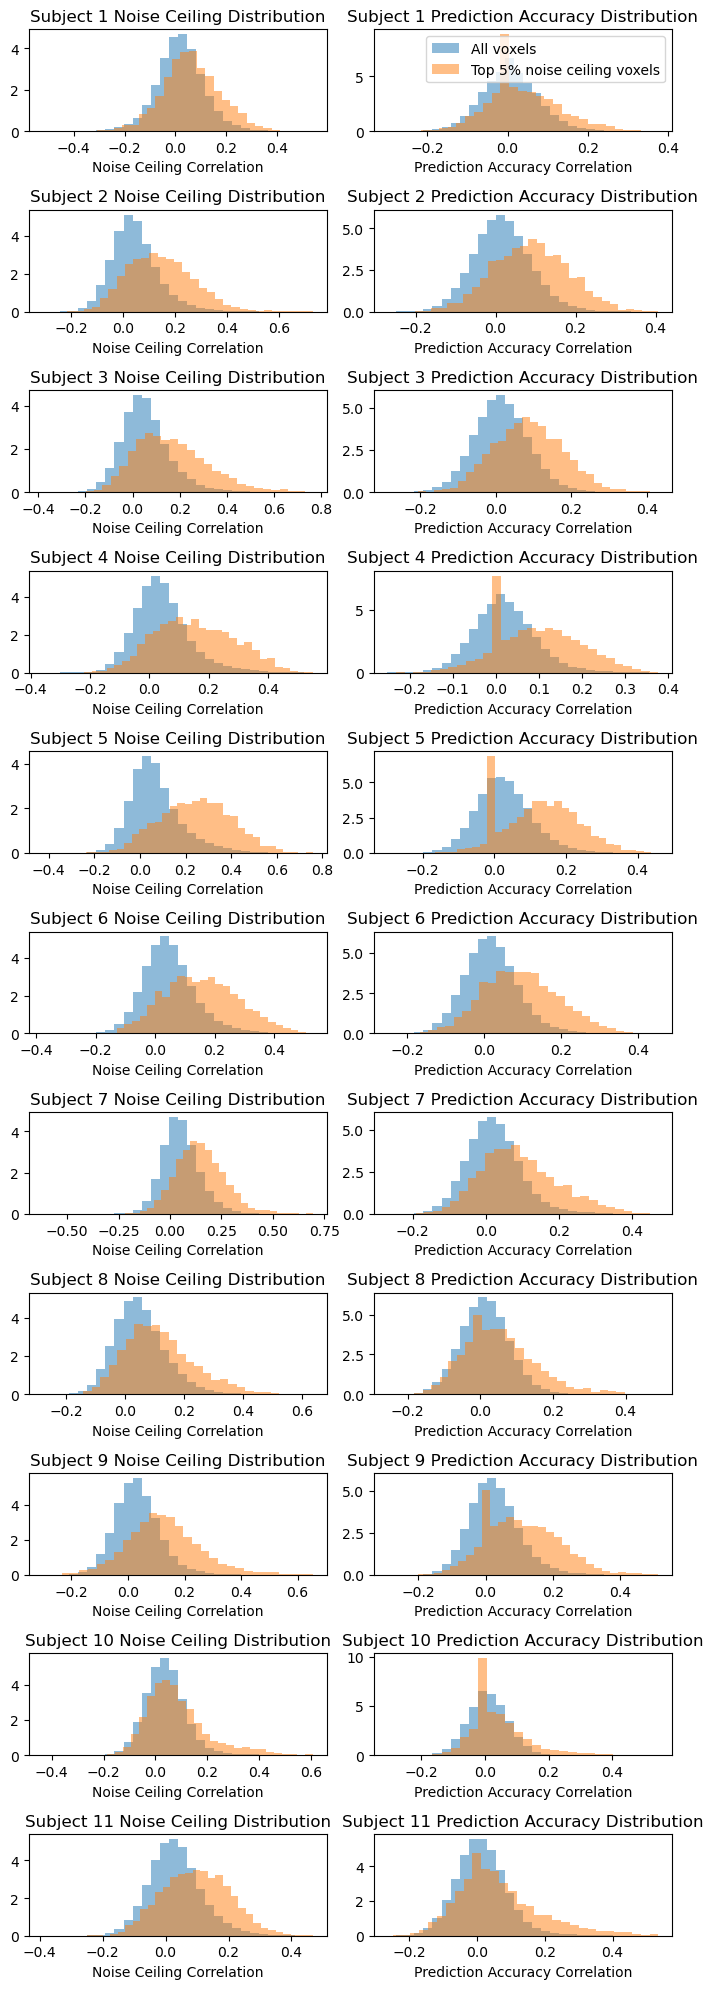

In [28]:
# Analyze the relationship between prediction accuracy and noise ceiling

plt.figure(figsize=(7, 20))
for subj in range(n_subj):
    # load prediction results
    result_data = np.load(f'results\\S{subj+1:02d}_results.npz')
    restored_corrs = result_data['restored_corrs']
    # load noise ceiling data
    noise_ceiling_data = np.load(f'results\\S{subj+1:02d}_noise_ceiling.npz')
    noise_ceiling = noise_ceiling_data['noise_ceiling']
    # # save as mat file
    # scipy.io.savemat(f'results\\S{subj+1:02d}_results.mat', 
    #                  {'noise_ceiling': noise_ceiling, 'restored_corrs': restored_corrs, 
    #                   'significant_voxel_indices': result_data['significant_voxel_indices'],
    #                   })


    
    # pick voxels with the highest 5% correlation values
    n_top_vertices = int(0.05 * restored_corrs.shape[0])
    top_vertex_indices = np.argsort(restored_corrs)[-n_top_vertices:]
    # check these voxels' noise ceiling values
    top_vertex_noise_ceiling = np.array(noise_ceiling)[top_vertex_indices]
    # # pick significant voxels's noise ceiling
    # top_vertex_noise_ceiling = np.array(noise_ceiling)[significant_voxel_indices]

    # plot a histogram of noise ceiling values for these top vertices
    plt.subplot(n_subj, 2, 2*(subj + 1) - 1)
    # underlay with all the noise ceiling values
    # normalize histogram to make area=1
    plt.hist(noise_ceiling, bins=30, alpha=0.5, label='All voxels', density=True)
    plt.hist(top_vertex_noise_ceiling, bins=30, alpha=0.5, label='Top 5% prediction accuracy voxels', density=True)
    plt.xlabel('Noise Ceiling Correlation')
    plt.title(f'Subject {subj+1} Noise Ceiling Distribution')


    # pick voxels with top noise ceiling values
    n_top_nc_vertices = int(0.05 * restored_corrs.shape[0])
    top_nc_vertex_indices = np.argsort(noise_ceiling)[-n_top_nc_vertices:]
    # check these voxels' correlation values
    top_nc_vertex_corrs = restored_corrs[top_nc_vertex_indices]
    # plot a histogram of correlation values for these top noise ceiling vertices
    plt.subplot(n_subj, 2, 2*(subj + 1))
    # underlay with all the correlation values
    plt.hist(restored_corrs, bins=30, alpha=0.5, label='All voxels', density=True)
    plt.hist(top_nc_vertex_corrs, bins=30, alpha=0.5, label='Top 5% noise ceiling voxels', density=True)
    plt.xlabel('Prediction Accuracy Correlation')
    plt.title(f'Subject {subj+1} Prediction Accuracy Distribution')
    if subj == 0:
        plt.legend()

plt.tight_layout()


## Map data to fsaverage

Because subject ID and mapper files don't correspond, we need to find out which mapper correspond to which subject id by finding datasets with equal number of voxels.

In [ ]:
# # [ONE-OFF] Find out number of voxels in each mapper files
# mapper_n_voxels = np.zeros(len(mapper_files), dtype=int)
# response_n_voxels = np.zeros(n_subj, dtype=int)

# for subj_id in range(len(mapper_files)):  
#     hdf_mapper = load_hdf_all('data\\mappers\\' + mapper_files[subj_id])
#     mapper_n_voxels[subj_id] = hdf_mapper['/voxel_to_fsaverage_shape'][1]

# # Find out number of voxels in each response file and match to mapper files
# response_n_voxels = np.zeros(n_subj, dtype=int) 
# mapper_idx = np.zeros(n_subj, dtype=int)
# for subj_id in range(n_subj):
    
#     hdf_response = load_hdf_all('data\\responses\\' + response_files[subj_id])
#     response_n_voxels[subj_id] = hdf_response['/zPresp'].shape[1]
#     mapper_idx[subj_id] = np.where(mapper_n_voxels == response_n_voxels[subj_id])[0][0]

# print(f'Mapper voxels: {mapper_n_voxels}, Response voxels: {response_n_voxels}')
# # Now they should match
# print(response_n_voxels)
# print(mapper_n_voxels[mapper_idx])

In [166]:
# We keep the corresondence between response and mapper files here so we don't have to run the above cells every time
mapper_idx = [ 0,  2,  3,  4,  5,  6, 10,  1,  7,  8,  9]
response_n_voxels = [81133, 73023, 76390, 80615, 92970, 75590, 73675, 80350, 79936, 87742, 85277]

# we keep the corresponding mapper file name and subject name as a dictionary
mapper_subj_idx = {'S01':mapper_files[mapper_idx[0]],'S02':mapper_files[mapper_idx[1]],'S03':mapper_files[mapper_idx[2]],'S04':mapper_files[mapper_idx[3]],'S05':mapper_files[mapper_idx[4]],'S06':mapper_files[mapper_idx[5]],'S07':mapper_files[mapper_idx[6]],'S08':mapper_files[mapper_idx[7]],'S09':mapper_files[mapper_idx[8]],'S10':mapper_files[mapper_idx[9]],'S11':mapper_files[mapper_idx[10]]}
mapper_subj_idx


{'S01': 'AH_mappers.hdf',
 'S02': 'BG_mappers.hdf',
 'S03': 'DS_mappers.hdf',
 'S04': 'JG_mappers.hdf',
 'S05': 'ML_mappers.hdf',
 'S06': 'NNS0_mappers.hdf',
 'S07': 'WH_mappers.hdf',
 'S08': 'AN_mappers.hdf',
 'S09': 'SP_mappers.hdf',
 'S10': 'SS_mappers.hdf',
 'S11': 'TZ_mappers.hdf'}

In [ ]:
# # [ONE-OFF] save mapper as mat files for each subject
# for subj,subj_map in mapper_subj_idx.items():
#     hdf_mapper = load_hdf_all(f'data\\mappers\\{subj_map}')
#     voxel_to_fsaverage_shape = hdf_mapper['/voxel_to_fsaverage_shape']
#     voxel_to_fsaverage_indices = hdf_mapper['/voxel_to_fsaverage_indices']
#     voxel_to_fsaverage_indptr = hdf_mapper['/voxel_to_fsaverage_indptr']
#     voxel_to_fsaverage_data = hdf_mapper['/voxel_to_fsaverage_data']
#     # save as mat file
#     scipy.io.savemat(f'results\\{subj}_mapper.mat', 
#                      {'voxel_to_fsaverage_shape': voxel_to_fsaverage_shape,
#                       'voxel_to_fsaverage_indices': voxel_to_fsaverage_indices,
#                       'voxel_to_fsaverage_indptr': voxel_to_fsaverage_indptr,
#                       'voxel_to_fsaverage_data': voxel_to_fsaverage_data})

In [ ]:
# Load a mapper for a subject
curr_subj = 1
hdf_mapper = load_hdf_all('data\\mappers\\' + mapper_subj_idx['S0' + str(curr_subj+1)])
# Restore the sparse mapper matrix
fsaverage_mapper = restore_csr(
    data=hdf_mapper['/voxel_to_fsaverage_data'],
    indices=hdf_mapper['/voxel_to_fsaverage_indices'],
    indptr=hdf_mapper['/voxel_to_fsaverage_indptr'],
    shape=tuple(hdf_mapper['/voxel_to_fsaverage_shape'])
)


# Verify if the mapper correspond to the response voxels
assert response_n_voxels[curr_subj]==fsaverage_mapper.shape[1], 'Mapper and response voxel number mismatch!'

In [104]:
# Project correlation and significance maps to fsaverage surface
# load results
loaded_data = np.load(f'results\\S{curr_subj+1:02d}_results.npz')
restored_corrs = loaded_data['restored_corrs']
significant_voxel_indices = loaded_data['significant_voxel_indices']
# restore significant voxel indicies into a sparse vector
significant_voxels = np.zeros(restored_corrs.shape[0], dtype=bool)
significant_voxels[significant_voxel_indices] = True
fsaverage_corrs = restored_corrs @ fsaverage_mapper.T  # shape: n_fsaverage_vertices
fsaverage_significant_voxels = significant_voxels @ fsaverage_mapper.T
# Visualize mean beta response as well
hdf_response = load_hdf_all('data\\responses\\' + response_files[curr_subj])
fsaverage_meanbeta = np.mean(hdf_response['/zPresp'], axis=0) @ fsaverage_mapper.T

Loading file:data\responses\S02_BOLD.hdf
h5py top-level groups: ['zPresp', 'zRresp']
Loaded dataset /zPresp shape=(291, 73023) dtype=float64
Loaded dataset /zRresp shape=(3737, 73023) dtype=float64
Loaded keys: ['/zPresp', '/zRresp']


In [172]:
# export mapped data to hdf5 files
want_subj = [9]
for subj in want_subj:
    # train data
    hdf_response = load_hdf_all('data\\responses\\' + response_files[subj])
    train_response = hdf_response['/zRresp']  # shape: n_timepoints x n_voxels
    test_response = hdf_response['/zPresp']  # shape: n_time
    hdf_mapper = load_hdf_all(f'data\\mappers\\' + mapper_subj_idx['S' + str(subj+1)])
    fsaverage_mapper = restore_csr(
        data=hdf_mapper['/voxel_to_fsaverage_data'],
        indices=hdf_mapper['/voxel_to_fsaverage_indices'],
        indptr=hdf_mapper['/voxel_to_fsaverage_indptr'],
        shape=tuple(hdf_mapper['/voxel_to_fsaverage_shape'])
    )
    
    test_mapped = hdf_response['/zPresp'] @ fsaverage_mapper.T
    train_mapped = hdf_response['/zRresp'] @ fsaverage_mapper.T

    # save to hdf5
    with h5py.File(f'results\\S{subj+1:02d}_fsaverage_BOLD.hdf5', 'w') as f:
        f.create_dataset('test_mapped', data=test_mapped)
        f.create_dataset('train_mapped', data=train_mapped)
    print(f'Subject {subj+1}: Exported fsaverage mapped results to hdf5 file.')

Loading file:data\responses\S10_BOLD.hdf
h5py top-level groups: ['zPresp', 'zRresp']
Loaded dataset /zPresp shape=(291, 87742) dtype=float64
Loaded dataset /zRresp shape=(3737, 87742) dtype=float64
Loaded keys: ['/zPresp', '/zRresp']
Loading file:data\mappers\SS_mappers.hdf
h5py top-level groups: ['flatmap_curvature', 'flatmap_mask', 'flatmap_rois', 'roi_mask_AC', 'roi_mask_Broca', 'roi_mask_EBA', 'roi_mask_FBA', 'roi_mask_FEF', 'roi_mask_FFA', 'roi_mask_FO', 'roi_mask_IPS', 'roi_mask_LO', 'roi_mask_LTC', 'roi_mask_M1F', 'roi_mask_M1H', 'roi_mask_M1M', 'roi_mask_MT+', 'roi_mask_OFA', 'roi_mask_OPA', 'roi_mask_PMvh', 'roi_mask_PPA', 'roi_mask_RSC', 'roi_mask_S1F', 'roi_mask_S1H', 'roi_mask_S1M', 'roi_mask_S2F', 'roi_mask_S2H', 'roi_mask_SFE', 'roi_mask_SMAf', 'roi_mask_SMAh', 'roi_mask_SMAs', 'roi_mask_STG', 'roi_mask_STS', 'roi_mask_TPJ', 'roi_mask_V1', 'roi_mask_V2', 'roi_mask_V3', 'roi_mask_V3A', 'roi_mask_V3B', 'roi_mask_V4', 'roi_mask_V7', 'roi_mask_pIC', 'roi_mask_sPMv', 'voxel_to

# Load language localizers

I use this section to export localizers into matlab...

In [ ]:

PARCELDIR = './data/lang_parcels/'
d_parcel_folders = {
    'lang_SN220': 'fsaverage',
    'lang_SN8': 'fsaverage_frontal',
}

"""
Load the anatomical language parcels, where the three frontal LH parcels were probabilistically drawn by KNK and GT on 20240615 on the LH. They were mirrored for the RH.                    
We take the three frontal ones (integers 1,2,3 in the LH; and 7,8,9 in th RH) from lang_SN8 and the rest from lang_SN220 (4,5,6 in the LH; 10,11,12 in the RH)
"""
# Add the rest of the lang parcels (LH = 4 5 6, RH 10 11 12) from lang_SN220 to the neural_meta df (still col: parc_lang_SN8)
hemis = ['lh', 'rh']
for hemi in hemis: 

    fname_lang_SN220_parcel = join(PARCELDIR, d_parcel_folders['lang_SN220'],
                            f'{hemi}.parcels_language_fsaverage_REGULARIZED.gii')  # 163842
    lang_SN220_parcel = nib.load(fname_lang_SN220_parcel).darrays[0].data

    # For each unique number in the lang_parcel, count how many vertices have that number
    unique, counts = np.unique(lang_SN220_parcel, return_counts=True)
    d_unique_counts = dict(zip(unique, counts))
    print(f'Number of vertices in each lang parcel ({hemi}): {d_unique_counts}')

    fname_lang_SN8_parcel = join(PARCELDIR, d_parcel_folders['lang_SN8'],
                            f'{hemi}.parcels_language_fsaverage_frontal_SN8.gii')  # 163842
    lang_SN8_parcel = nib.load(fname_lang_SN8_parcel).darrays[0].data
    assert len(np.unique(lang_SN8_parcel)) == 4 # includes 0

    if hemi == 'lh':
        for parc_int in [4, 5, 6]: # three temporal ones
            lang_SN8_parcel[lang_SN220_parcel == parc_int] = parc_int
            lang_parcel_lh = lang_SN8_parcel
    elif hemi == 'rh':
        for parc_int in [10, 11, 12]: # three temporal ones
            lang_SN8_parcel[lang_SN220_parcel == parc_int] = parc_int
            lang_parcel_rh = lang_SN8_parcel
        
    # For each unique number in the lang_parcel, count how many vertices have that number
    unique, counts = np.unique(lang_parcel_lh if hemi == 'lh' else lang_parcel_rh, return_counts=True)
    d_unique_counts = dict(zip(unique, counts))
    print(f'Number of vertices in each lang parcel ({hemi}): {d_unique_counts}')

assert fsaverage_corrs.shape[0]/2 == lang_parcel_lh.shape[0] == len(fsaverage_meanbeta)/2

# export lang_parcel_lh and lang_parcel_rh together as a csv file
lang_parcels = np.vstack((lang_parcel_lh, lang_parcel_rh))
np.savetxt('data\\lang_parcels\\lang_parcels_combined.csv', lang_parcels, delimiter=',', fmt='%d')

Number of vertices in each lang parcel (lh): {np.float32(0.0): np.int64(149439), np.float32(1.0): np.int64(847), np.float32(2.0): np.int64(1130), np.float32(3.0): np.int64(1182), np.float32(4.0): np.int64(2593), np.float32(5.0): np.int64(7041), np.float32(6.0): np.int64(1610)}
Number of vertices in each lang parcel (lh): {np.float32(0.0): np.int64(146081), np.float32(1.0): np.int64(1956), np.float32(2.0): np.int64(1702), np.float32(3.0): np.int64(2859), np.float32(4.0): np.int64(2593), np.float32(5.0): np.int64(7041), np.float32(6.0): np.int64(1610)}
Number of vertices in each lang parcel (rh): {np.float32(0.0): np.int64(148830), np.float32(7.0): np.int64(674), np.float32(8.0): np.int64(1359), np.float32(9.0): np.int64(1262), np.float32(10.0): np.int64(2802), np.float32(11.0): np.int64(7813), np.float32(12.0): np.int64(1102)}
Number of vertices in each lang parcel (rh): {np.float32(0.0): np.int64(145906), np.float32(7.0): np.int64(1747), np.float32(8.0): np.int64(1665), np.float32(9.0)

In [ ]:
lh_roi = [1,2,3,4,5]
rh_roi = [7,8,9,10,11]
# Plot correlations in the language parcels only
fsaverage_corrs_lang = fsaverage_corrs.copy()
fsaverage_corrs_lang_left = fsaverage_corrs_lang[:fsaverage_corrs_lang.shape[0]//2]
fsaverage_corrs_lang_right = fsaverage_corrs_lang[fsaverage_corrs_lang.shape[0]//2:]
for parc_int in range(0, 13):
    if parc_int not in lh_roi + rh_roi:
        fsaverage_corrs_lang_left[lang_parcel_lh == parc_int] = 0.0
        fsaverage_corrs_lang_right[lang_parcel_rh == parc_int] = 0.0
        

I couldn't get pycortex to work, so I switched to matlab for brain visualization from here on.